In [ ]:
# Refactor binary_classifier_trainer
# Do leave one image and sample out cross validation
# How to train on replica and test on section?
# How to train on section and test on replica?

# Using the tissue mean create classification model using binary_classifier_trainer
# Using the pixels create classification model using binary_classifier_trainer

# Check if background mean contains signal as than we can use the Z-score

# I or Ciro should Recreate the FIG 8 + S12 T0 and T1 HCA using the 1000 lipids

# Fig S9 should change or even be deleted depending on out text.

# Fog S10 cannot be used if not background a zscore normalization - not
# important if not using out pipeline on the dhg

In [1]:
# Sort local packages import
import sys

sys.path.append(".")

# Import the necessary libraries
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from tqdm.notebook import tqdm
from typing import List, Tuple, Dict
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from processing import TICNormalizer, MeanSegmentation

In [2]:
# Define current folder using this file
CWD = Path(".")
# Define folder that contains dataset
DHG_PATH = CWD / ".." / "data" / "DHG"
# Define folder that contains raw data
RAW_DATA = DHG_PATH / "raw_txt"
# Define folder to save processed data
PROCESSED_DATA = DHG_PATH / "processed_txt"
# Define file that contains metadata
METADATA_PATH = DHG_PATH / "txt_metadata.csv"
# Define path to save plots and results
FIGURES_PATH = CWD / "new_correlation_classification"
FIGURES_PATH.mkdir(exist_ok=True, parents=True)
# Define mass range start value
MZ_START = 600
# Define mass range end value
MZ_END = 900
# Define mass resolution of the data
MASS_RESOLUTION = 0.02
# Define representative peaks
REPRESENTATIVE_PEAKS = [794.5, 834.5, 886.6]

In [3]:
# Read metadata csv
metadata_df = pd.read_csv(METADATA_PATH)

In [4]:
def process_spectral_data_to_image(
    txt_file_path: Path
) -> Tuple[np.ndarray, np.ndarray]:
  """Function to process the spectral data in a txt file to a 3D image array.

  Args:
    txt_file_path (Path): The path to the txt file containing the spectral data.

  Returns:
    Tuple[np.ndarray, np.ndarray]: A tuple containing the 3D image array and 
        the mzs array.

  """
  # Read the file and extract the mzs
  with open(txt_file_path, "r") as f:
    mzs = [float(mz) for mz in f.readlines()[3].strip().split("\t") if mz != ""]
  # Read the file and extract the data
  df = pd.read_csv(txt_file_path, skiprows=4, sep="\t", header=None)
  df = df.iloc[:, 1:-2]
  # Rename the columns
  df.columns = ["x", "y"] + mzs
  # Convert the 'x' and 'y' columns to integers
  df['x'] = (df['x'] * 10).astype(int)
  df['y'] = (df['y'] * 10).astype(int)
  # Shift the 'x' and 'y' coordinates to start from 0
  if df['x'].min() < 0:
    df['x'] = df['x'] + abs(df['x'].min())
  if df['y'].min() < 0:
    df['y'] = df['y'] + abs(df['y'].min())
  # Extract the 'x' and 'y' coordinates, and the spectral data
  x_coords = df['x'].values
  y_coords = df['y'].values
  spectra_data = df.drop(['x', 'y'], axis=1).values
  # Preallocate the 3D image array
  img = np.zeros(
      (y_coords.max() + 1, x_coords.max() + 1, spectra_data.shape[1])
  )
  # Use numpy's advanced indexing to place the spectra_data in the img array
  img[y_coords, x_coords, :] = spectra_data
  # Return the 3D image array and the mzs array
  return img, np.array(mzs)


def merge_mzs_and_intensities(
    mzs: np.ndarray, intensities: np.ndarray, threshold: float = 0.02
) -> Tuple[np.ndarray, np.ndarray]:
  """Function to merge mzs and intensities of a single image based on a
      threshold.

  Args:
    mzs (np.ndarray): Array of mzs.
    intensities (np.ndarray): Image of intensities corresponding to the mzs.
    threshold (float, optional): The threshold to merge mzs. Defaults to 0.02.

  Returns:
    Tuple[np.ndarray, np.ndarray]: A tuple containing the merged mzs and 
      intensities.

  """
  # Sort mzs and intensities based on mzs order to simplify the process
  sorted_indices = np.argsort(mzs)
  mzs_sorted = mzs[sorted_indices]
  intensities_sorted = intensities[:, :, sorted_indices]
  # Initialize the merged mzs and intensities
  merged_mzs = []
  merged_intensities = []
  # Iterate over the mzs
  i = 0
  while i < len(mzs_sorted):
    # Check if the next mz is within the threshold
    if i < len(mzs_sorted
              ) - 1 and abs(mzs_sorted[i] - mzs_sorted[i + 1]) < threshold:
      # Merge the current and next mz
      new_mz = (mzs_sorted[i] + mzs_sorted[i + 1]) / 2
      new_intensity = intensities_sorted[:, :, i] + intensities_sorted[:, :,
                                                                       i + 1]
      merged_mzs.append(new_mz)
      merged_intensities.append(new_intensity)
      # Skip the next mz as it has been merged
      i += 2
    else:
      # If no merge, keep the current mz and intensity
      merged_mzs.append(mzs_sorted[i])
      merged_intensities.append(intensities_sorted[:, :, i])
      i += 1
  # Convert back to numpy arrays
  merged_mzs = np.array(merged_mzs)
  merged_intensities = np.stack(merged_intensities, axis=2)
  # Return the merged mzs and intensities
  return merged_mzs, merged_intensities


def pair_corr(
    mean_1: np.ndarray, mean_2: np.ndarray, mzs_1: np.ndarray,
    mzs_2: np.ndarray, tolerance: float = 0.02
) -> float:
  """Function to compute the correlation between two mean spectra.

  Args:
    mean_1 (np.ndarray): The mean spectrum of the first image.
    mean_2 (np.ndarray): The mean spectrum of the second image.
    mzs_1 (np.ndarray): The mzs of the first image.
    mzs_2 (np.ndarray): The mzs of the second image.
    tolerance (float, optional): The tolerance to match mzs. Defaults to 0.02.

  Returns:
    float: The correlation between the two mean spectra.

  """
  # Create arrays for new means and matched m/z values
  new_mean_1 = []
  new_mean_2 = []
  # Compute the absolute difference matrix between mzs_1 and mzs_2
  diff_matrix = np.abs(mzs_1[:, np.newaxis] - mzs_2)
  # Find matches within the tolerance
  matches = diff_matrix < tolerance
  # Keep track of matched indices in mzs_2
  matched_indices_2 = set()
  # First pass: match mzs_1 to mzs_2
  for i, _ in enumerate(mzs_1):
    # Check if there is a match
    match_idx = np.where(matches[i])[0]
    if match_idx.size > 0:
      # We know the first match will be the only one due to larger gap > 0.02
      closest_idx = match_idx[0]
      new_mean_1.append(mean_1[i])
      new_mean_2.append(mean_2[closest_idx])
      matched_indices_2.add(closest_idx)
    else:
      # No match for mzs_1, append zero for mean_2
      new_mean_1.append(mean_1[i])
      new_mean_2.append(0)
  # Second pass: add unmatched mzs_2 with 0 for mzs_1
  for j, _ in enumerate(mzs_2):
    if j not in matched_indices_2:
      new_mean_1.append(0)
      new_mean_2.append(mean_2[j])
  # Convert to numpy arrays
  new_mean_1 = np.array(new_mean_1)
  new_mean_2 = np.array(new_mean_2)
  # Calculate and return the correlation
  return np.corrcoef(new_mean_1, new_mean_2)[0, 1]


def plot_corr_matrix(
    corr_df: pd.DataFrame, y_label: str, x_label: str,
    mark_biopsies: bool = False, sort_biopsies: bool = False,
    figsize: Tuple[float, float] = (11.69, 8.27), cbar: bool = False,
    annot: bool = False
) -> Tuple[plt.Figure, plt.Axes]:
  """Function to plot correlation matrix.

  Args:
      corr_df (pd.DataFrame): Correlation matrix.
      y_label (str): Y axis label.
      x_label (str): X axis label.
      mark_biopsies (bool, optional): Indicator if to mark biopsies from the
          same patient in red box. Defaults to False.
      sort_biopsies (bool, optional): Indicator if to sort biopsies in figure.
          Defaults to False.
      figsize (Tuple[float, float], optional): Figure size. Defaults to
          (11.69, 8.27).
      cbar (bool, optional): Indicator to whether to draw a color bar. Defaults
          to False.
      annot (bool, optional): Indicator to whether to write the data value in
          each cell. Defaults to False.

  Returns:
      Tuple[plt.Figure, plt.Axes]: Figure and axes.
  """
  # Create figure
  fig, ax = plt.subplots(1, 1, figsize=figsize, tight_layout=True)

  # Sort biopsies by their number
  if sort_biopsies:
    index_keys = corr_df.index.to_series(
    ).apply(lambda s: int(re.sub(r"HG |-s|-r|_.", "", s))).sort_values().index
    col_keys = corr_df.columns.to_series(
    ).apply(lambda s: int(re.sub(r"HG |-s|-r|_.", "", s))).sort_values().index
    corr_df = corr_df.loc[index_keys.to_list(), col_keys.to_list()]

  # Plot correlation matrix
  ax = sns.heatmap(
      corr_df, annot=annot, cmap="YlGn", fmt=".2f", vmin=-1, vmax=1,
      linewidth=.5, linecolor='w', square=True, cbar=cbar, ax=ax
  )
  ax.set_ylabel(y_label.capitalize())
  ax.set_xlabel(x_label.capitalize())

  # Mark cells of biopsies from the same patient
  if mark_biopsies:
    for index_i, i in enumerate(corr_df.columns):
      for index_j, j in enumerate(corr_df.index):
        i_num = re.sub(r"HG |-s|-r|_.", "", i)
        j_num = re.sub(r"HG |-s|-r|_.", "", j)
        if i_num == j_num:
          ax.add_patch(
              Rectangle(
                  (index_i, index_j), 1, 1, fill=False, edgecolor="red", lw=2
              )
          )
  return fig, ax


def plot_corr_ranks(
    corr_df: pd.DataFrame, figsize: Tuple[float, float] = (11.69, 8.27)
) -> Tuple[plt.Figure, plt.Axes]:
  """Function to plot correlation ranks for pair biopsies.

  Args:
      corr_df (pd.DataFrame): Correlation matrix.
      figsize (Tuple[float, float], optional): Figure size. Defaults to
          (11.69, 8.27).

  Returns:
      Tuple[plt.Figure, plt.Axes]: Figure and axes.
  """
  # Get ranks of correlation matrix
  ranks = corr_df.rank(axis=0, method="min", ascending=False).astype(int)
  # Define list to save pair ranks
  pair_ranks = []
  # Get ranks of pairs
  for i in corr_df.columns:
    for j in corr_df.index:
      i_num = re.sub(r"HG |-s|-r|_.", "", i)
      j_num = re.sub(r"HG |-s|-r|_.", "", j)
      if i_num == j_num:
        pair_ranks.append(ranks.loc[j, i])
  # Create figure
  fig, ax = plt.subplots(1, 1, figsize=figsize, tight_layout=True)
  # Plot pair correlation rank count
  ax = sns.countplot(
      data=pd.DataFrame({"ranks": pair_ranks}), x="ranks", ax=ax,
      color="#3274a1"
  )
  ax.set_ylabel("Count")
  ax.set_xlabel("Pairs correlation rank")
  ax.set_ylim((0, 21))
  return fig, ax


def plot_corr_distribution(
    corr_df: pd.DataFrame, figsize: Tuple[float, float] = (11.69, 8.27)
) -> Tuple[plt.Figure, plt.Axes]:
  """Function to plot correlation distribution.

  Args:
      corr_df (pd.DataFrame): Correlation matrix.
      figsize (Tuple[float, float], optional): Figure size. Defaults to
          (11.69, 8.27).

  Returns:
      Tuple[plt.Figure, plt.Axes]: Figure and axes.
  """
  # Create figure
  fig, ax = plt.subplots(1, 1, figsize=figsize, tight_layout=True)
  # Plot pair correlation rank count
  ax = sns.histplot(
      corr_df.values.reshape(-1), bins=np.arange(-0.05, 1.1, 0.1),
      stat="probability", ax=ax, color="#3274a1"
  )
  ax.set_ylabel("Probability")
  ax.set_xlabel("Correlation")
  ax.set_ylim((0, 1))
  return fig, ax


def get_dataset_mzs(metadata_df: pd.DataFrame) -> List[Tuple[np.ndarray, str]]:
  """Function to get the mzs for all files in the dataset.

  Args:
    metadata_df (pd.DataFrame): The metadata dataframe.

  Returns:
    List[Tuple[np.ndarray, str]]: A list of tuples containing the mzs and the
        sample type.

  """
  # Define list to store all mzs
  all_mzs = []
  # Go over all files
  for p in Path(PROCESSED_DATA).iterdir():
    # Get mzs
    mzs = np.load(p / "mzs.npy")
    # Append to all mzs
    if metadata_df[metadata_df.sample_file_name == p.stem
                  ].sample_type.values[0] == 'replica':
      all_mzs.append((mzs, "r"))
    else:
      all_mzs.append((mzs, "s"))
  # Return all mzs
  return all_mzs


def find_common_mzs(
    *mz_lists: List[np.ndarray], tolerance: float = 0.02
) -> np.ndarray:
  """Function to find the common m/z values across multiple lists of m/z values.

  Args:
    tolerance (float, optional): The tolerance for closeness in m/z values.

  Returns:
    np.ndarray: An array of common m/z values.

  """
  # Start with the first list as a base reference
  common_mzs = []
  # Iterate through each m/z in the first list
  for mz in mz_lists[0]:
    # Assume the current m/z value is common
    is_common = True
    # Compare it with the corresponding values in all other lists
    for mz_list in mz_lists[1:]:
      # Check if at least one value in the current list is within the tolerance
      if not np.any(np.abs(mz - mz_list) < tolerance):
        # If not, the current m/z value is not common
        is_common = False
        break
    # If the value is within tolerance in all lists, add to the common list
    if is_common:
      common_mzs.append(mz)
  # Return the common m/z values as a numpy array
  return np.array(common_mzs)


def build_mz_mapping(mz_lists: List[np.ndarray],
                     tolerance: float = 0.02) -> List[Dict[float, float]]:
  """Function to build a mapping of common m/z values across multiple lists.

  Args:
    mz_lists (List[np.ndarray]): A list of m/z value lists.
    tolerance (float, optional): The tolerance for closeness in m/z values.

  Returns:
    List[Dict[float, float]]: A list of dictionaries mapping common m/z values
        to corresponding m/z values in each list

  """
  # Step 1: Get the common m/z values using the updated function
  max_common_mzs = find_common_mzs(*mz_lists, tolerance=tolerance)
  # Step 2: Build the mapping for each list
  mappings = []
  # For each list of m/z values
  for mz_list in mz_lists:
    # Initialize the mapping for the current list
    mz_mapping = {}
    # For each common m/z value, find the closest m/z value in the current list
    for common_mz in max_common_mzs:
      # Find the m/z value in the current list that is closest to the current
      # common m/z value
      differences = np.abs(common_mz - mz_list)
      min_diff_index = np.argmin(differences)
      # If the closest m/z value is within tolerance, map it
      if differences[min_diff_index] <= tolerance:
        mz_mapping[common_mz] = mz_list[min_diff_index]
      else:
        mz_mapping[common_mz] = None  # No m/z value within tolerance
    # Append the mapping for the current list
    mappings.append(mz_mapping)
  # Return the list of mappings
  return mappings

In [7]:
#  Get normalizer object
normalizer = TICNormalizer()
# Get the aw files
raw_files = list(Path(RAW_DATA).iterdir())
# Loop through the files
for p in tqdm(raw_files, total=len(raw_files)):
  # Subset metadata for the current file
  l_metadata_df = metadata_df.loc[metadata_df["file_name"] == p.stem].copy()
  # Get image and mzs
  img, mzs = process_spectral_data_to_image(p)
  # Apply normalization to the intensities
  img_norm = np.apply_along_axis(
      lambda intensities: (normalizer.normalize((mzs, intensities)))[1], axis=2,
      arr=img
  )
  # Merge mz channels with difference less than 0.02 as they are likely to be
  # the same mz
  mzs_merged, img_norm_merged = merge_mzs_and_intensities(
      mzs, img_norm, threshold=MASS_RESOLUTION
  )
  # Apply segmentation
  segmenter = MeanSegmentation(
      mzs_merged, REPRESENTATIVE_PEAKS, MASS_RESOLUTION * 4
  )
  img_segmented = segmenter.segment(img_norm_merged)
  # Loop through the ROIs
  for index, roi in l_metadata_df.iterrows():
    # Define path to ROI file after processing
    output_path = PROCESSED_DATA / f"{roi.sample_file_name}"
    # Create output folder if doesn't exist
    output_path.mkdir(parents=True, exist_ok=True)
    # Get the ROI coordinates
    x_min, x_max = roi["x_min"], roi["x_max"]
    y_min, y_max = roi["y_min"], roi["y_max"]
    # Get the ROI image
    roi_img_norm = img_norm_merged[y_min:y_max, x_min:x_max, :]
    # Get the ROI segmented image
    roi_img_segmented = img_segmented[y_min:y_max, x_min:x_max]
    # Save the information
    np.save(output_path / f"tic_normalized.npy", roi_img_norm)
    np.save(output_path / f"segmentation.npy", roi_img_segmented)
    np.save(output_path / f"mzs.npy", mzs_merged)

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

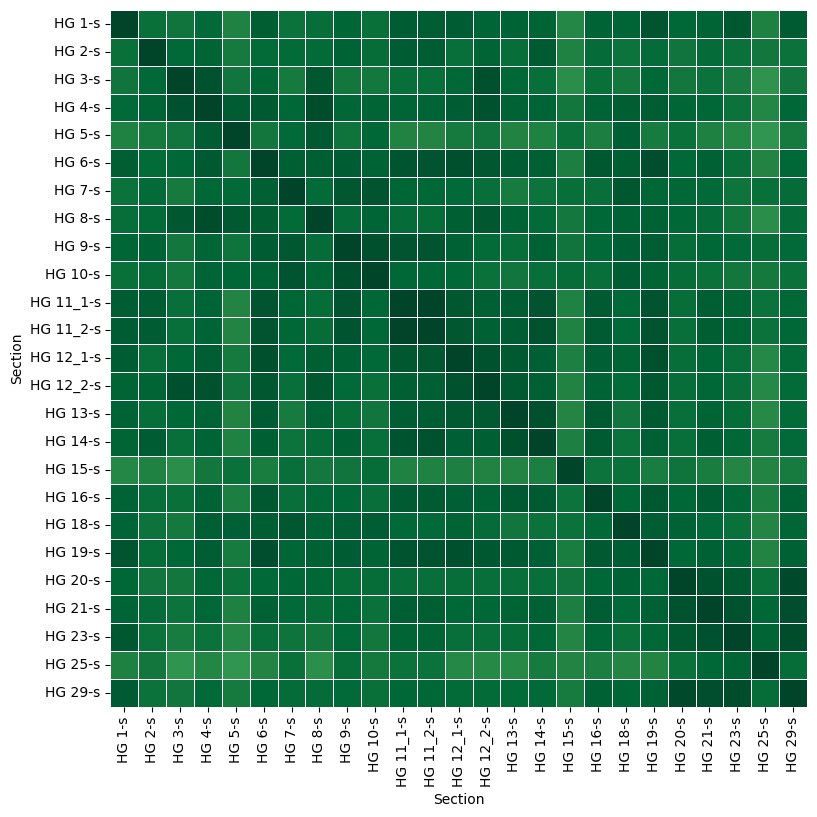

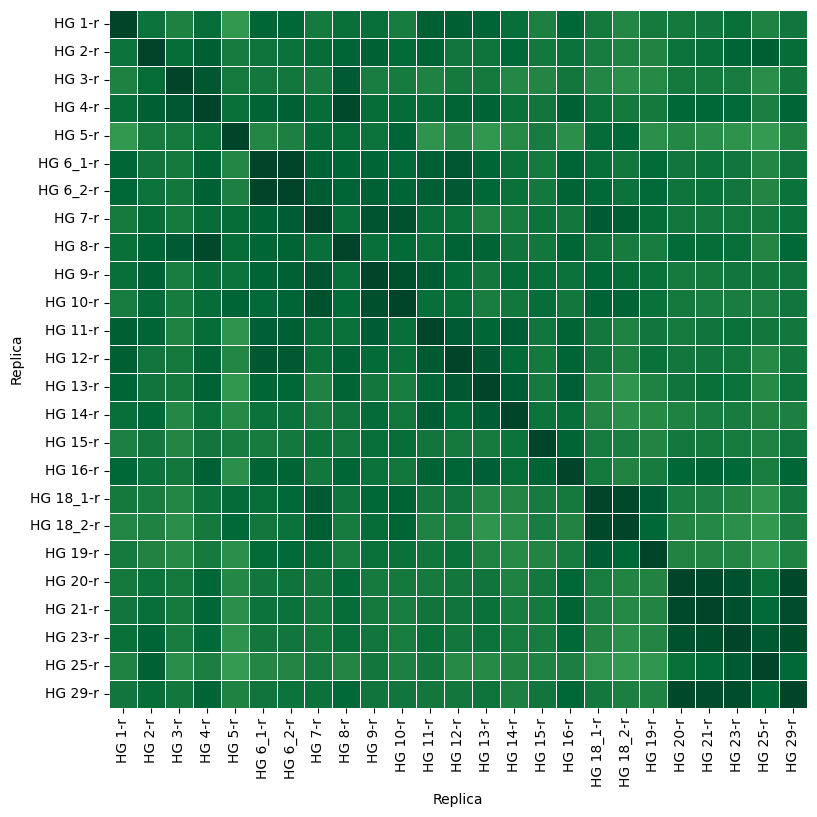

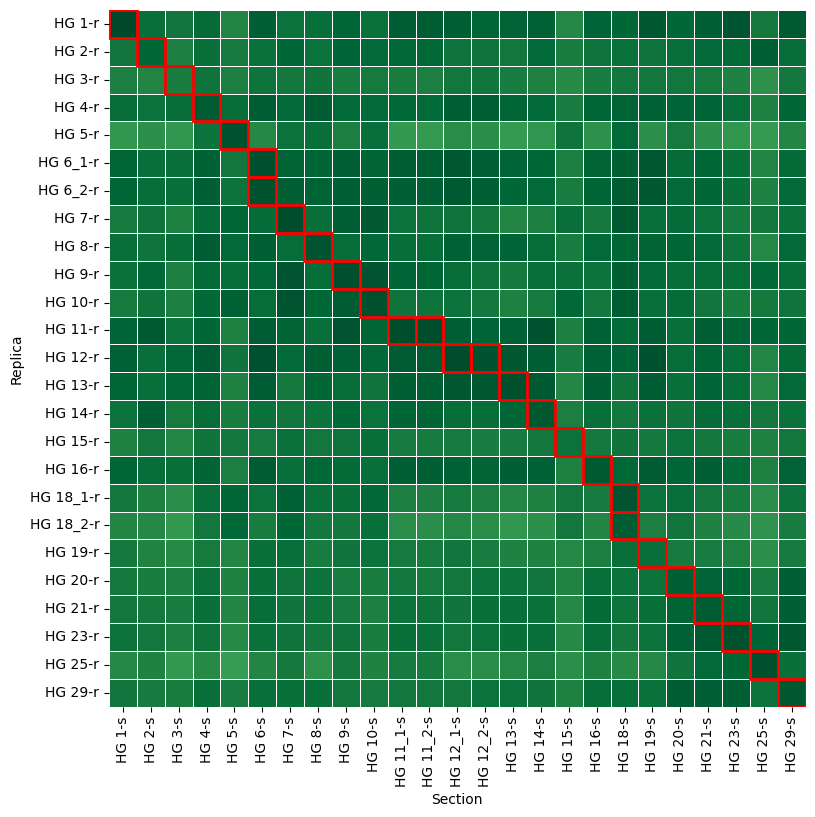

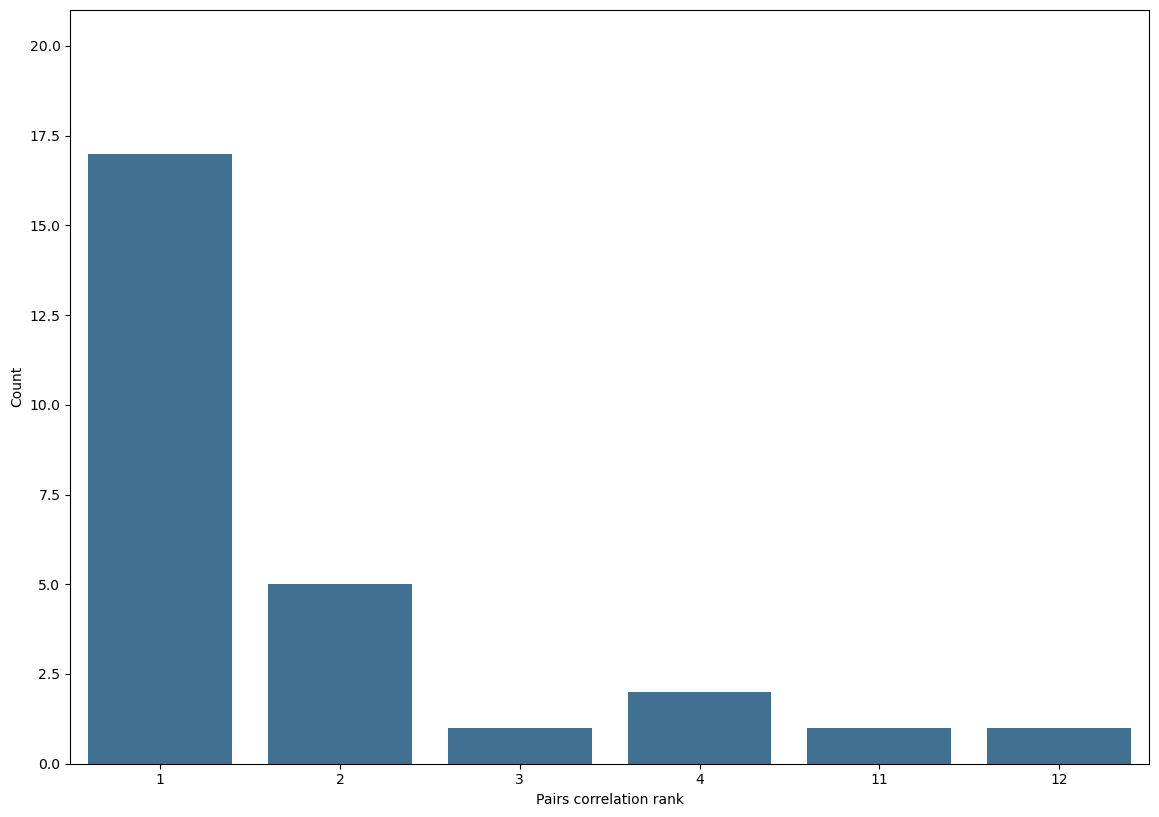

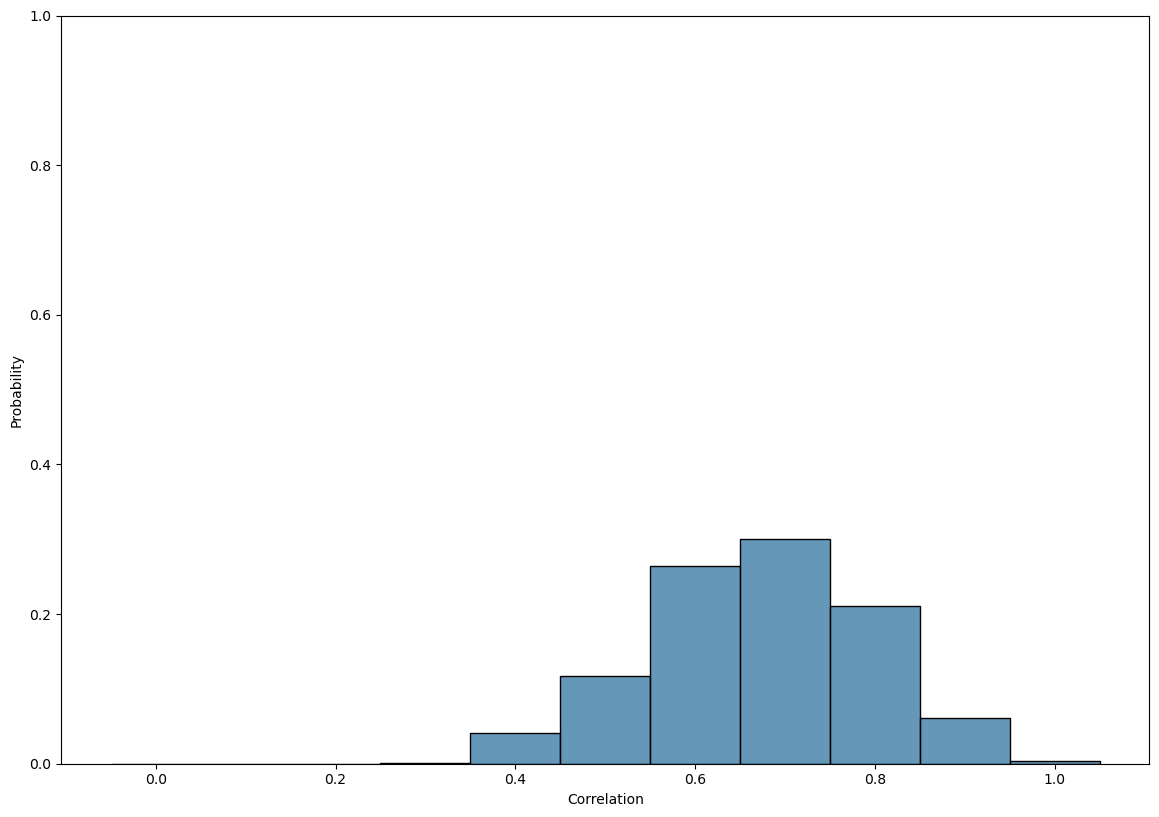

In [5]:
# Get the processed files
processed_files = list(Path(PROCESSED_DATA).iterdir())
# Create a correlation matrix to store the results
correlation_matrix_all_mzs = np.zeros(
    (len(processed_files), len(processed_files))
)
# Loop through the files
for i, p1 in tqdm(enumerate(processed_files), total=len(processed_files)):
  # Loop through the files
  for j, p2 in enumerate(processed_files):
    # Load the intensities
    img1 = np.load(p1 / "tic_normalized.npy")
    img2 = np.load(p2 / "tic_normalized.npy")
    # load mzs
    mzs1 = np.load(p1 / "mzs.npy")
    mzs2 = np.load(p2 / "mzs.npy")
    # load segmentations
    seg1 = np.load(p1 / "segmentation.npy")
    seg2 = np.load(p2 / "segmentation.npy")
    # Get the mean of the segmented data
    mean_1 = img1[seg1 == 1].mean(axis=0)
    mean_2 = img2[seg2 == 1].mean(axis=0)
    # Calculate the correlation
    correlation = pair_corr(mean_1, mean_2, mzs1, mzs2, MASS_RESOLUTION)
    correlation_matrix_all_mzs[i, j] = correlation
# Create a dataframe from the correlation matrix
corr_df_all_mzs = pd.DataFrame(
    correlation_matrix_all_mzs, columns=[p.stem for p in processed_files],
    index=[p.stem for p in processed_files]
)
# Get the correlation matrix of replica-replica samples
r_samples = [col for col in corr_df_all_mzs.columns if '-r' in col]
r_samples = sorted(
    r_samples, key=lambda x:
    int(x.replace("HG ", "").replace("_", " ").replace("-", " ").split(' ')[0])
)
corr_df_r = corr_df_all_mzs.loc[r_samples, r_samples]

# Get the correlation matrix of section-section samples
s_samples = [col for col in corr_df_all_mzs.columns if '-s' in col]
s_samples = sorted(
    s_samples, key=lambda x:
    int(x.replace("HG ", "").replace("_", " ").replace("-", " ").split(' ')[0])
)
corr_df_s = corr_df_all_mzs.loc[s_samples, s_samples]
# Get the correlation matrix of replica-section samples
corr_df_rs = corr_df_all_mzs.loc[r_samples, s_samples]
# Plot the section-section correlation matrix
fig, ax = plot_corr_matrix(
    corr_df_s, "Section", "Section", mark_biopsies=False, sort_biopsies=True
)
plt.tight_layout()
plt.savefig(
    FIGURES_PATH / "section_section_correlation_heatmap.png", transparent=True,
    bbox_inches='tight', dpi=1200
)
plt.show()
# Plot the replica-replica correlation matrix
fig, ax = plot_corr_matrix(
    corr_df_r, "Replica", "Replica", mark_biopsies=False, sort_biopsies=True
)
plt.tight_layout()
plt.savefig(
    FIGURES_PATH / "replica_replica_correlation_heatmap.png", transparent=True,
    bbox_inches='tight', dpi=1200
)
plt.show()
# Plot the replica-section correlation matrix
fig, ax = plot_corr_matrix(
    corr_df_rs, "Replica", "Section", mark_biopsies=True, sort_biopsies=True
)
plt.tight_layout()
plt.savefig(
    FIGURES_PATH / "replica_section_correlation_heatmap.png", transparent=True,
    bbox_inches='tight', dpi=1200
)
plt.show()
# Plot the replica-section correlation ranks
fig, ax = plot_corr_ranks(corr_df_rs)
plt.tight_layout()
plt.savefig(
    FIGURES_PATH / "replica_section_correlation_distribution.png",
    transparent=True, bbox_inches='tight', dpi=1200
)
plt.show()
# Plot the replica-section correlation distribution
fig, ax = plot_corr_distribution(corr_df_rs)
plt.tight_layout()
plt.savefig(
    FIGURES_PATH / "replica_section_correlation_ranks.png", transparent=True,
    bbox_inches='tight', dpi=1200
)
plt.show()

In [5]:
# Get the mzs for all files
all_mzs = get_dataset_mzs(metadata_df)
# Build the mz mapping for all files to the common mzs
mappings = build_mz_mapping(
    [np.array(mzs) for mzs, _ in all_mzs], tolerance=0.02
)
# Get the common mzs
common_mzs = np.array(list(mappings[0].keys()))
# Loop through the files
for i, p in enumerate(tqdm(list(Path(PROCESSED_DATA).iterdir()))):
  # Get mzs
  img = np.load(p / "tic_normalized.npy")
  mzs = np.load(p / "mzs.npy")
  # Get the mapping for the current file
  mapping = mappings[i]
  # Create a new image for the mapped mzs
  mapped_img = np.zeros((img.shape[0], img.shape[1], len(mapping)))
  # Map the intensities to the new image
  for j, (common_mz, mz) in enumerate(mapping.items()):
    if mz is not None:
      mz_index = np.where(mzs == mz)[0][0]
      mapped_img[:, :, j] = img[:, :, mz_index]
  # Save the mapped image
  np.save(p / "mapped_tic_normalized.npy", mapped_img)
  # Save the common m/z values
  np.save(p / "common_mzs.npy", common_mzs)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

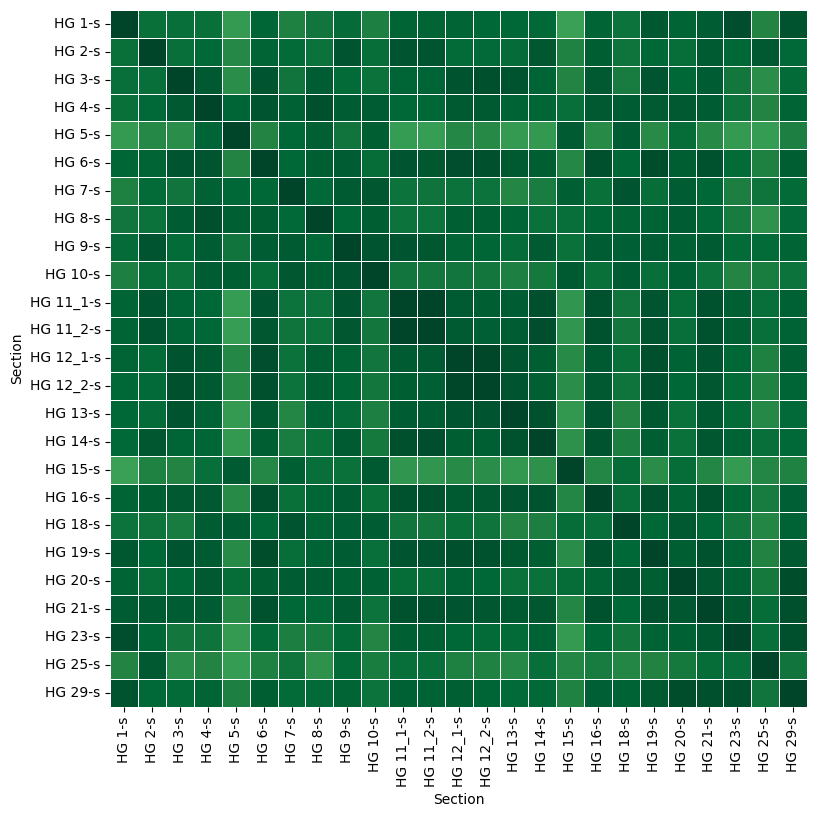

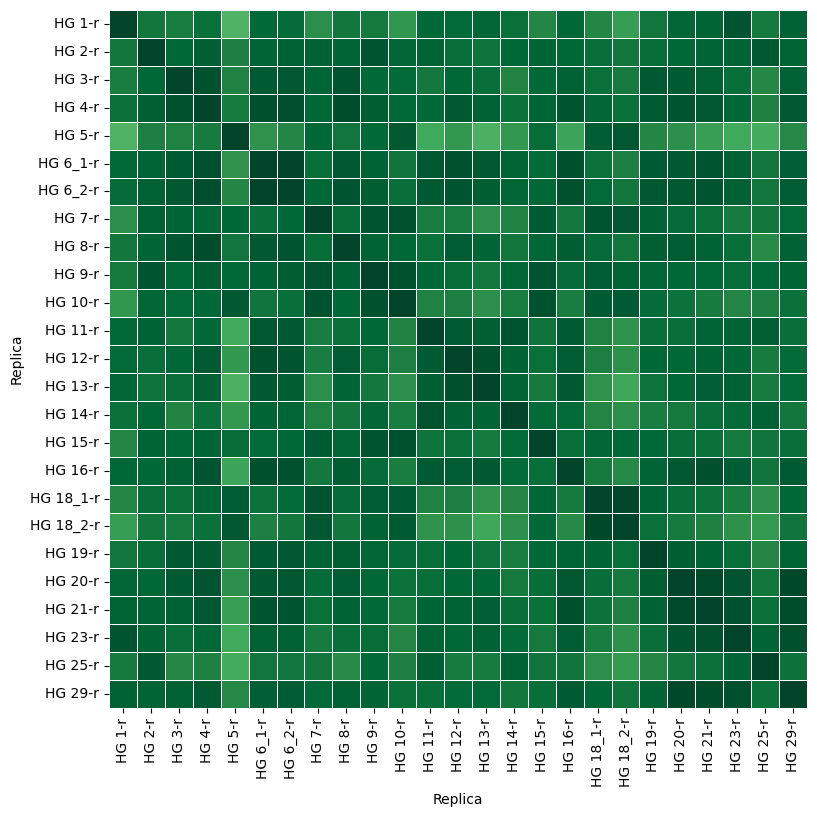

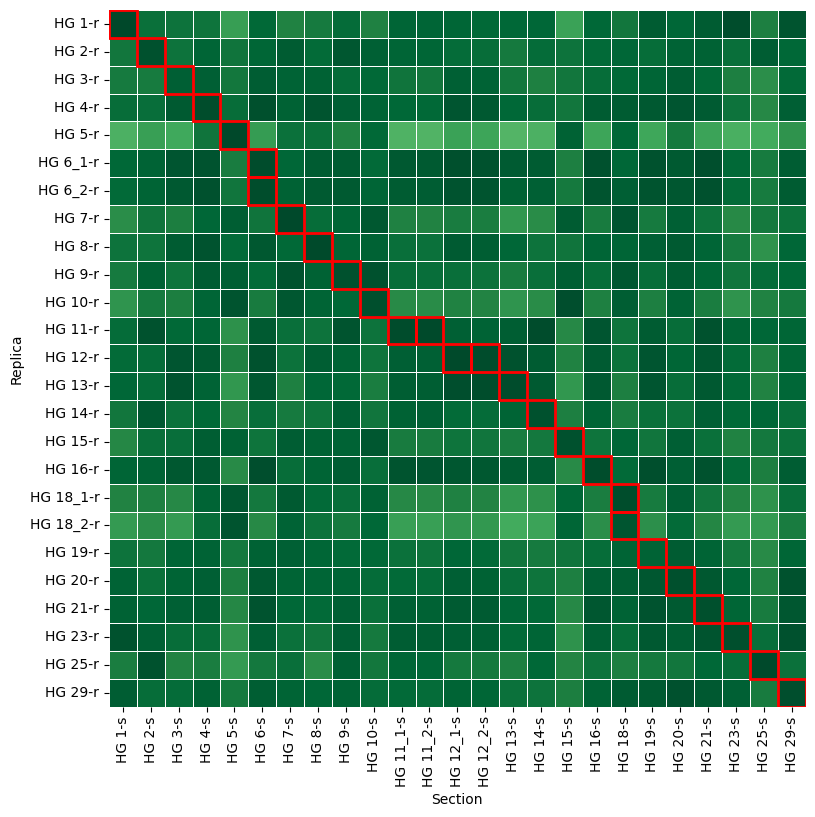

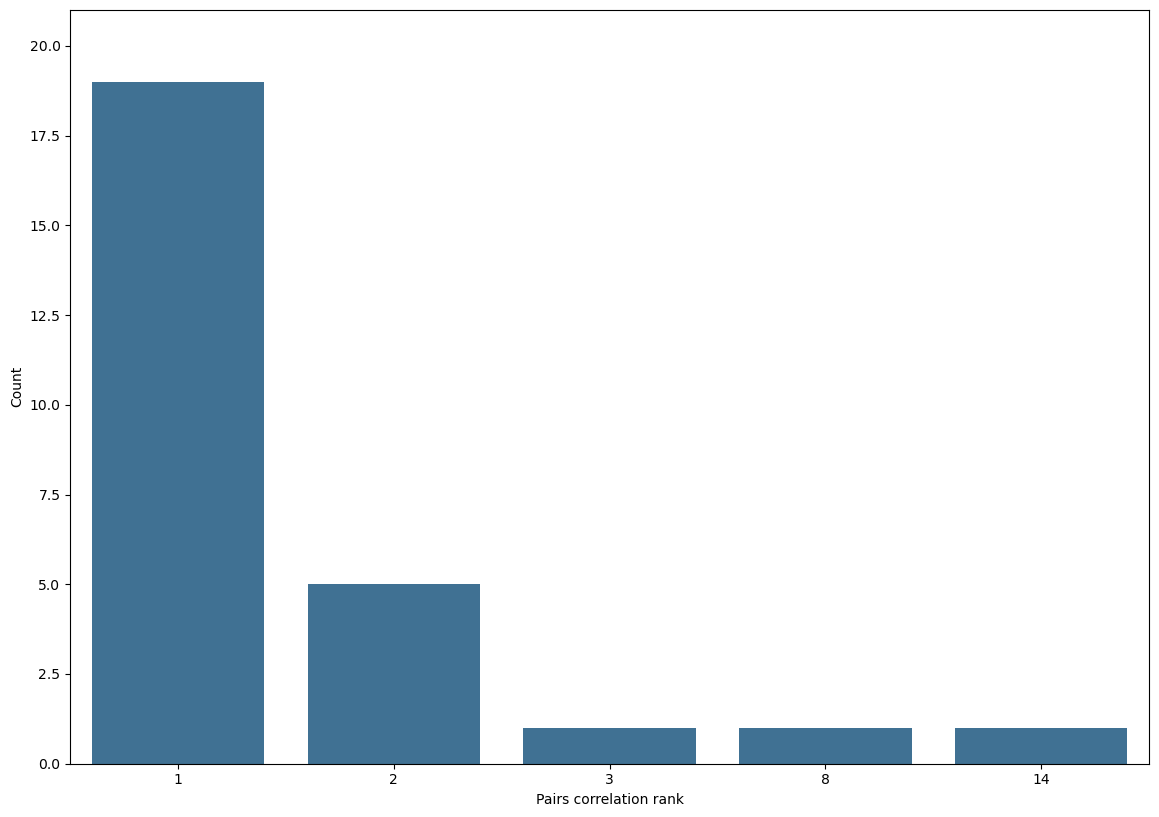

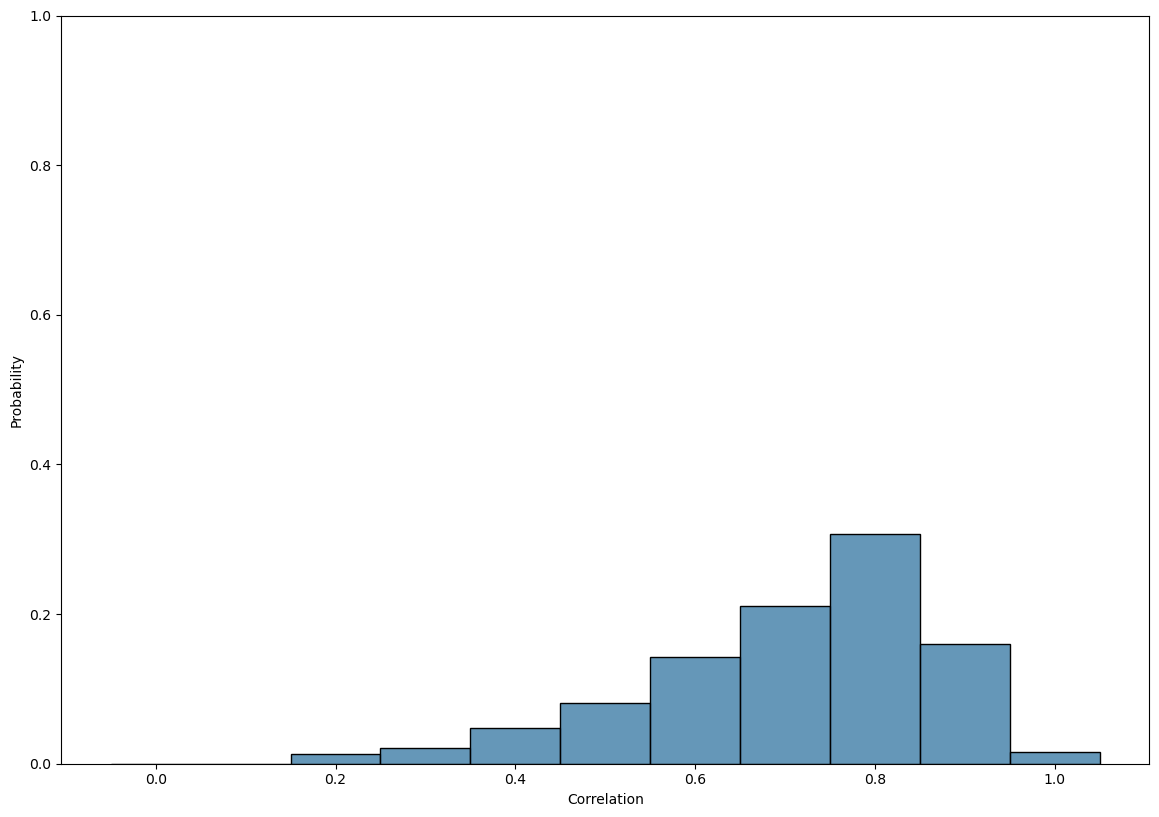

In [7]:
# Create a correlation matrix to store the results
correlation_matrix_common_mzs = np.zeros(
    (len(processed_files), len(processed_files))
)
# Loop through the files
for i, p1 in tqdm(enumerate(processed_files), total=len(processed_files)):
  # Loop through the files
  for j, p2 in enumerate(processed_files):
    # Load the intensities
    img1 = np.load(p1 / "mapped_tic_normalized.npy")
    img2 = np.load(p2 / "mapped_tic_normalized.npy")
    # load mzs
    mzs = np.load(p1 / "mzs.npy")
    # load segmentations
    seg1 = np.load(p1 / "segmentation.npy")
    seg2 = np.load(p2 / "segmentation.npy")
    # Get the mean of the segmented data
    mean_1 = img1[seg1 == 1].mean(axis=0)
    mean_2 = img2[seg2 == 1].mean(axis=0)
    # Calculate the correlation
    correlation = np.corrcoef(mean_1, mean_2)[0, 1]
    correlation_matrix_common_mzs[i, j] = correlation
# Create a dataframe from the correlation matrix
corr_df_common_mzs = pd.DataFrame(
    correlation_matrix_common_mzs, columns=[p.stem for p in processed_files],
    index=[p.stem for p in processed_files]
)
# Get the correlation matrix of replica-replica samples
corr_df_common_mzs_r = corr_df_common_mzs.loc[r_samples, r_samples]
# Get the correlation matrix of section-section samples
corr_df_common_mzs_s = corr_df_common_mzs.loc[s_samples, s_samples]
# Get the correlation matrix of replica-section samples
corr_df_common_mzs_rs = corr_df_common_mzs.loc[r_samples, s_samples]
# Plot the section-section correlation matrix
fig, ax = plot_corr_matrix(
    corr_df_common_mzs_s, "Section", "Section", mark_biopsies=False,
    sort_biopsies=True
)
plt.tight_layout()
plt.savefig(
    FIGURES_PATH / "section_section_correlation_heatmap_common_mzs.png",
    transparent=True, bbox_inches='tight', dpi=1200
)
plt.show()
# Plot the replica-replica correlation matrix
fig, ax = plot_corr_matrix(
    corr_df_common_mzs_r, "Replica", "Replica", mark_biopsies=False,
    sort_biopsies=True
)
plt.tight_layout()
plt.savefig(
    FIGURES_PATH / "replica_replica_correlation_heatmap_common_mzs.png",
    transparent=True, bbox_inches='tight', dpi=1200
)
plt.show()
# Plot the replica-section correlation matrix
fig, ax = plot_corr_matrix(
    corr_df_common_mzs_rs, "Replica", "Section", mark_biopsies=True,
    sort_biopsies=True
)
plt.tight_layout()
plt.savefig(
    FIGURES_PATH / "replica_section_correlation_heatmap_common_mzs.png",
    transparent=True, bbox_inches='tight', dpi=1200
)
plt.show()
# Plot the replica-section correlation ranks
fig, ax = plot_corr_ranks(corr_df_common_mzs_rs)
plt.tight_layout()
plt.savefig(
    FIGURES_PATH / "replica_section_correlation_ranks_common_mzs.png",
    transparent=True, bbox_inches='tight', dpi=1200
)
plt.show()
# Plot the replica-section correlation distribution
fig, ax = plot_corr_distribution(corr_df_common_mzs_rs)
plt.tight_layout()
plt.savefig(
    FIGURES_PATH / "replica_section_correlation_distribution_common_mzs.png",
    transparent=True, bbox_inches='tight', dpi=1200
)
plt.show()

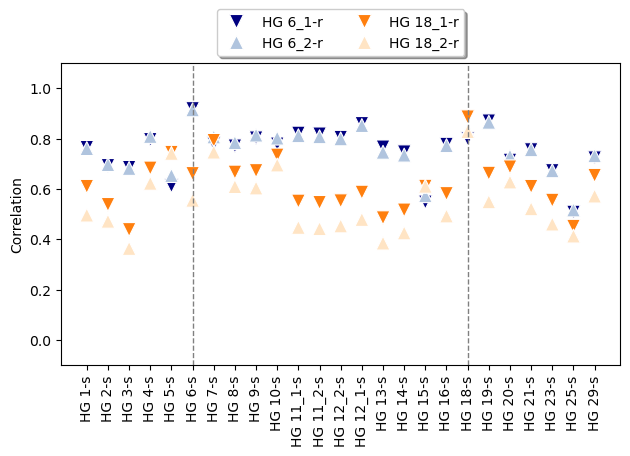

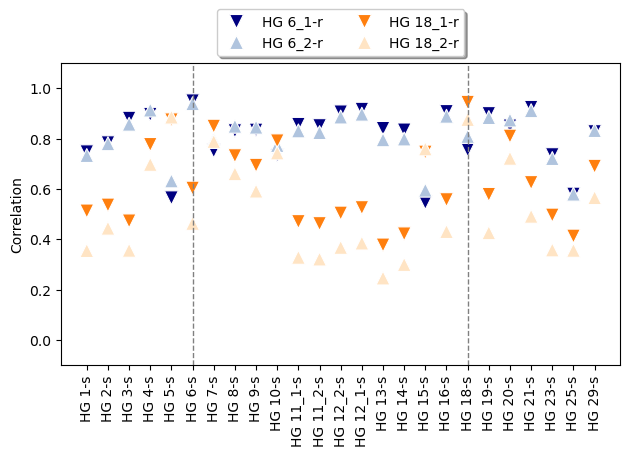

In [8]:
# Define the biopsies with multiple replicas
multiple_replicas = ["HG 6_1-r", "HG 6_2-r", "HG 18_1-r", "HG 18_2-r"]

# Define the color palette
palette = {
    "HG 6_1-r": "navy", "HG 6_2-r": "lightsteelblue", "HG 18_1-r": "tab:orange",
    "HG 18_2-r": "bisque"
}

# Loop through the correlation matrices
for df, plot_name in zip(
    [corr_df_rs, corr_df_common_mzs_rs], ["", "common_mzs"]
):
  # Create figure
  fig, ax = plt.subplots(1)
  # Create scatter plot
  ax = sns.scatterplot(
      data=df.T.loc[:, multiple_replicas], ax=ax, s=100,
      markers=["v", "^", "v", "^"], palette=palette
  )
  # Set plot params
  ax.set_ylim(-0.1, 1.1)
  ax.tick_params('x', labelrotation=90)
  ax.set_ylabel(f"Correlation")
  ax.set_xlabel("")
  lgnd = ax.legend(
      title="", loc='upper center', bbox_to_anchor=(0.5, 1.20), ncol=2,
      fancybox=True, shadow=True
  )
  lgnd.legend_handles[0]._sizes = [100]
  lgnd.legend_handles[1]._sizes = [100]
  # Add vertical lines for representative sections
  for tick in ["HG 6-s", "HG 18-s"]:
    # Get the index of the tick in your data and plot vertical line
    tick_pos = df.columns.get_loc(tick)
    ax.axvline(x=tick_pos, color="gray", linestyle="--", linewidth=1)
  # Show plot
  plt.tight_layout()
  plot_name = "multiple_replicas_correlation" + f"_{plot_name}" if plot_name else "multiple_replicas_correlation"
  plt.savefig(
      FIGURES_PATH / f"{plot_name}.png", transparent=True, bbox_inches='tight',
      dpi=1200
  )
  plt.show()

In [9]:
# Save the correlation matrices
corr_df_r.to_csv(FIGURES_PATH / "corr_df_r.csv")
corr_df_s.to_csv(FIGURES_PATH / "corr_df_s.csv")
corr_df_rs.to_csv(FIGURES_PATH / "corr_df_rs.csv")
corr_df_common_mzs_r.to_csv(FIGURES_PATH / "corr_df_common_mzs_r.csv")
corr_df_common_mzs_s.to_csv(FIGURES_PATH / "corr_df_common_mzs_s.csv")
corr_df_common_mzs_rs.to_csv(FIGURES_PATH / "corr_df_common_mzs_rs.csv")

In [ ]:
# Classification

In [5]:
import json
import random
import warnings
import optuna
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from typing import Any, Union
from joblib import Parallel, delayed


def load_data(
    processed_files: List[Path], metadata_df: pd.DataFrame
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray,
           np.ndarray]:
  """Function to load the data.

  Args:
    processed_files (List[Path]): List of processed files.
    metadata_df (pd.DataFrame): Metadata dataframe.

  Returns:
    Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, 
        np.ndarray]: A tuple containing the spectras, file names, sample 
        file names, sample numbers, sample types, and WHO grades.

  """
  # Define lists to store the data
  spectras = []
  file_names = []
  sample_file_names = []
  sample_numbers = []
  sample_types = []
  who_grades = []
  # Loop through the processed files
  for p in tqdm(
      processed_files, total=len(processed_files), desc="Loading data"
  ):
    # Get the spectras
    img = np.load(p / "mapped_tic_normalized.npy")
    seg = np.load(p / "segmentation.npy")
    spectras.append(img[seg])
    num_spectras = img[seg].shape[0]
    # Get the file name, sample file name, sample number, sample type, and
    # WHO grade
    metadata = metadata_df[metadata_df.sample_file_name == p.stem]
    file_name = metadata.file_name.values[0]
    sample_file_name = metadata.sample_file_name.values[0]
    sample_number = metadata.sample_number.values[0]
    sample_type = metadata.sample_type.values[0]
    who_grade = metadata.who_grade.values[0]
    # Append to the lists
    file_names.append([file_name] * num_spectras)
    sample_file_names.append([sample_file_name] * num_spectras)
    sample_numbers.append([sample_number] * num_spectras)
    sample_types.append([sample_type] * num_spectras)
    who_grades.append([who_grade] * num_spectras)
  # Convert lists to numpy arrays
  return (
      np.concatenate(spectras), np.concatenate(file_names),
      np.concatenate(sample_file_names), np.concatenate(sample_numbers),
      np.concatenate(sample_types), np.concatenate(who_grades)
  )


def convert_to_bulk(
    spectras: np.ndarray, file_names: np.ndarray, sample_file_names: np.ndarray,
    sample_numbers: np.ndarray, sample_types: np.ndarray, who_grades: np.ndarray
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray,
           np.ndarray]:
  """Function to convert the data to bulk.

  Args:
    spectras (np.ndarray): Array of data spectras.
    file_names (np.ndarray): Array of file names.
    sample_file_names (np.ndarray): Array of sample file names.
    sample_numbers (np.ndarray): Array of sample numbers.
    sample_types (np.ndarray): Array of sample types.
    who_grades (np.ndarray): Array of WHO grades.

  Returns:
    Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, 
        np.ndarray]: A tuple containing the bulk spectras, file names, 
        sample_file_names, sample numbers, sample types, and WHO grades.

  """
  # Create grouped indices by sample_file_name
  unique_sample_file_names = np.unique(sample_file_names)
  grouped_indices = {
      sample_file_name: np.where(sample_file_names == sample_file_name)[0]
      for sample_file_name in unique_sample_file_names
  }
  # Define lists to store the results
  mean_spectras = []
  file_names_bulk = []
  sample_file_names_bulk = []
  sample_numbers_bulk = []
  sample_types_bulk = []
  who_grades_bulk = []
  # Iterate over each group to compute the mean spectra and aggregate metadata
  for sample_file_name, indices in tqdm(
      grouped_indices.items(), desc="Converting to bulk"
  ):
    # Calculate the mean of the spectra for this group
    mean_spectrum = np.mean(spectras[indices], axis=0)
    # Extract metadata from the first index (as all values should be
    # identical within the group)
    file_name = file_names[indices[0]]
    sample_number = sample_numbers[indices[0]]
    sample_type = sample_types[indices[0]]
    who_grade = who_grades[indices[0]]
    # Append the results to the lists
    mean_spectras.append(mean_spectrum)
    file_names_bulk.append(file_name)
    sample_file_names_bulk.append(sample_file_name)
    sample_numbers_bulk.append(sample_number)
    sample_types_bulk.append(sample_type)
    who_grades_bulk.append(who_grade)
  # Return lists as numpy arrays
  return (
      np.array(mean_spectras), np.array(file_names_bulk),
      np.array(sample_file_names_bulk), np.array(sample_numbers_bulk),
      np.array(sample_types_bulk), np.array(who_grades_bulk)
  )


def separate_data_by_sample_type(
    X: np.ndarray, y: np.ndarray, batch_ids: np.ndarray,
    patient_ids: np.ndarray, sample_types: np.ndarray
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray,
           np.ndarray, np.ndarray, np.ndarray]:
  """Function to separate the data by sample type.

  Args:
    X (np.ndarray): The feature matrix.
    y (np.ndarray): The target vector.
    batch_ids (np.ndarray): The batch IDs.
    patient_ids (np.ndarray): The patient IDs.
    sample_types (np.ndarray): The sample types.

  Returns:
    Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, 
        np.ndarray, np.ndarray, np.ndarray]: A tuple containing the replica
        feature matrix, section feature matrix, replica target vector,
        section target vector, replica batch IDs, section batch IDs,
        replica patient IDs, and section patient IDs.

  """
  return (
      X[sample_types == 'replica'], X[sample_types == 'section'],
      y[sample_types == 'replica'], y[sample_types == 'section'
                                     ], batch_ids[sample_types == 'replica'],
      batch_ids[sample_types == 'section'
               ], patient_ids[sample_types == 'replica'
                             ], patient_ids[sample_types == 'section']
  )


def prepare_grouped_indices(batch_ids: np.ndarray) -> Dict[Any, np.ndarray]:
  """Function to prepare grouped indices for LOOCV.

  Args:
    batch_ids (np.ndarray): Array of batch IDs.

  Returns:
    Dict[Any, np.ndarray]: A dictionary containing the unique batch IDs as keys
        and the corresponding indices as values.

  """
  # Get unique values of batch IDs
  unique_vals = np.unique(batch_ids)
  # Create a dictionary to store the grouped indices
  grouped_indices = {val: np.where(batch_ids == val)[0] for val in unique_vals}
  return grouped_indices


def objective(
    trial, model_type: str, X_train: np.ndarray, y_train: np.ndarray,
    batch_ids_train: np.ndarray, seed: int
) -> float:
  """
  Objective function for Optuna to optimize hyperparameters of a model using 
      cross-validation.

  Args:
    trial (optuna.trial.Trial): A trial object that suggests hyperparameters.
    X_train (np.ndarray): Training feature matrix of shape (n_samples, 
        n_features).
    y_train (np.ndarray): Training target vector of shape (n_samples,).
    batch_ids (np.ndarray): Array of group IDs used to group samples for 
        cross-validation.
    seed (int): Random seed for reproducibility.

  Returns:
    float: The mean AUC score across the cross-validation folds for the 
        suggested hyperparameters.

  """
  # Suggest hyperparameters using Optuna for Logistic Regression
  if model_type == 'logistic_regression':
    C = trial.suggest_float('C', 1e-6, 1e+6, log=True)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    tol = trial.suggest_float('tol', 1e-4, 1e-2, log=True)
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs'])
    model = LogisticRegression(
        C=C, max_iter=max_iter, tol=tol, solver=solver, class_weight='balanced',
        random_state=seed
    )
  # Suggest hyperparameters using Optuna for Decision Tree
  elif model_type == 'decision_tree':
    max_depth = trial.suggest_int('max_depth', 1, 32)
    max_features = trial.suggest_categorical(
        'max_features', ['sqrt', 'log2', None]
    )
    model = DecisionTreeClassifier(
        max_depth=max_depth, max_features=max_features, class_weight='balanced', random_state=seed
    )
  # Suggest hyperparameters using Optuna for Random Forest
  elif model_type == 'random_forest':
    class_weight = trial.suggest_categorical(
        'class_weight', ['balanced', 'balanced_subsample']
    )
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 7)
    max_features = trial.suggest_categorical(
        'max_features', ['sqrt', 'log2', None]
    )
    model = RandomForestClassifier(
        class_weight=class_weight, n_estimators=n_estimators,
        max_depth=max_depth, max_features=max_features, random_state=seed
    )
  # Suggest hyperparameters using Optuna for XGBoost
  elif model_type == 'xgboost':
    max_depth = trial.suggest_int('max_depth', 3, 7)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1, log=True)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
    gamma = trial.suggest_float('gamma', 0, 5)
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    model = XGBClassifier(
        max_depth=max_depth, learning_rate=learning_rate, subsample=subsample,
        colsample_bytree=colsample_bytree, gamma=gamma,
        n_estimators=n_estimators, random_state=seed
    )
  # Suggest hyperparameters using Optuna for LightGBM
  else:
    max_depth = trial.suggest_int('max_depth', 3, 7)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1, log=True)
    num_leaves = trial.suggest_int('num_leaves', 30, 70)
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    model = LGBMClassifier(
        num_leaves=num_leaves, learning_rate=learning_rate,
        n_estimators=n_estimators, max_depth=max_depth, class_weight='balanced', 
        random_state=seed, verbose=-1
    )
  # Define cross-validation
  # TODO: try with StratifiedKFold
  skf = StratifiedGroupKFold(n_splits=3, shuffle=False)
  # Define predictions array
  predictions = np.zeros(y_train.shape)
  # Perform cross-validation with the suggested hyperparameters
  for train_idx, val_idx in skf.split(X_train, y_train, batch_ids_train):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, _ = y_train[train_idx], y_train[val_idx]
    with warnings.catch_warnings():
      # Suppress specific warnings during hyperparameter tuning
      warnings.simplefilter("ignore", category=ConvergenceWarning)
      if model_type == 'xgboost':
        class_weights = compute_class_weight('balanced', classes=np.unique(y_tr), y=y_tr)
        sample_weights = np.array([class_weights[int(y)] for y in y_train])
        model.fit(X_tr, y_tr, sample_weight=sample_weights)
      else:
        model.fit(X_tr, y_tr)
    predictions[val_idx] = model.predict_proba(X_val)[:, 1]
  # Calculate AUC score and return
  return roc_auc_score(y_train, predictions)


def optimize_hyperparameters(
    X_train: np.ndarray, y_train: np.ndarray, batch_ids_train: np.ndarray,
    model_type: str, seed: int, n_trials: int = 50, n_jobs: int = -1
) -> Dict[str, Any]:
  """Function to optimize hyperparameters using Optuna.

  Args:
    X_train (np.ndarray): Training feature matrix.
    y_train (np.ndarray): Training target vector.
    batch_ids_train (np.ndarray): Array of group IDs used to group samples for
        cross-validation.
    model_type (str): The type of model to optimize hyperparameters for.
    seed (int): Random seed for reproducibility.
    n_trials (int, optional): Number of trials for hyperparameter optimization.
    n_jobs (int, optional): Number of parallel jobs to run.
  
  Returns:
    Dict[str, Any]: A dictionary containing the best hyperparameters found

  """
  study = optuna.create_study(direction='maximize')
  study.optimize(
      lambda trial:
      objective(trial, model_type, X_train, y_train, batch_ids_train, seed),
      n_trials=n_trials, n_jobs=n_jobs
  )
  return study.best_params


def create_best_model(
    model_type: str, best_params: Dict[str, Any], seed: int
) -> Union[LogisticRegression, DecisionTreeClassifier, XGBClassifier,
           RandomForestClassifier, LGBMClassifier]:
  """Function to create the best model using the best hyperparameters.

  Args:
    model_type (str): he type of model to optimize hyperparameters for.
    best_params (Dict[str, Any]): Dictionary of best hyperparameters found.
    seed (int): Random seed for reproducibility.

  Returns:
    Union[LogisticRegression, DecisionTreeClassifier, XGBClassifier, 
        RandomForestClassifier, LGBMClassifier]: The best model.

  """
  # Create the best model for Logistic Regression
  if model_type == 'logistic_regression':
    best_model = LogisticRegression(**best_params, random_state=seed)
  # Create the best model for Decision Tree
  elif model_type == 'decision_tree':
    best_model = DecisionTreeClassifier(**best_params, random_state=seed)
  # Create the best model for XGBoost
  elif model_type == 'xgboost':
    best_model = XGBClassifier(**best_params, random_state=seed)
  # Create the best model for Random Forest
  elif model_type == 'random_forest':
    best_model = RandomForestClassifier(**best_params, random_state=seed)
  # Create the best model for LightGBM
  else:
    best_model = LGBMClassifier(**best_params, random_state=seed, verbose=-1)
  return best_model


def fit_and_calibrate_model(
    X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray,
    model_type: str, best_params: Dict[str, Any], seed: int
) -> np.ndarray:
  """Function to fit and calibrate a model using the best hyperparameters.

  Args:
    X_train (np.ndarray): Training feature matrix.
    y_train (np.ndarray): Training target vector.
    X_test (np.ndarray): Test feature matrix.
    model_type (str): The type of model to optimize hyperparameters for.
    best_params (Dict[str, Any]): Dictionary of best hyperparameters found.
    seed (in): Random seed for reproducibility.

  Returns:
    np.ndarray: Predictions for the test set.

  """
  # Create and fit the model using the best parameters
  best_model = create_best_model(model_type, best_params, seed)
  if model_type == 'xgboost':
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    sample_weights = np.array([class_weights[int(y)] for y in y_train])
    best_model.fit(X_train, y_train, sample_weight=sample_weights)
  else:
    best_model.fit(X_train, y_train)
  # Calibrate the model
  calibrated_classifier = CalibratedClassifierCV(
      best_model, method='sigmoid', cv='prefit'
  )
  calibrated_classifier.fit(X_train, y_train)
  # Make predictions
  return calibrated_classifier.predict_proba(X_test)[:, 1]


def train_and_predict_for_group(
    X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray,
    X_test_other: np.ndarray, batch_ids_train: np.ndarray, model_type: str,
    seed: int, best_params: Dict[str, Any] = None, n_trials: int = 50,
    n_jobs: int = -1
) -> Tuple[np.ndarray, np.ndarray, Dict[str, Any]]:
  """Function to train and predict for a group of samples.

  Args:
    X_train (np.ndarray): Training feature matrix.
    y_train (np.ndarray): Training target vector.
    X_test (np.ndarray): Test feature matrix.
    X_test_other (np.ndarray): Test feature matrix for the other sample type.
    batch_ids_train (np.ndarray): Array of group IDs used to group samples for
        cross-validation.
    model_type (str): The type of model to optimize hyperparameters for.
    seed (int): Random seed for reproducibility.
    best_params (Dict[str, Any], optional): Dictionary of best hyperparameters
        found. Defaults to None.
    n_trials (int, optional): Number of trials for hyperparameter optimization.
    n_jobs (int, optional): Number of parallel jobs to run.

  Returns:
    Tuple[np.ndarray, np.ndarray, Dict[str, Any]]: A tuple containing the
        predictions for the replica samples, predictions for the section
        samples, and the best hyperparameters found.

  """
  # Get the best hyperparameters if not provided
  if best_params is None:
    best_params = optimize_hyperparameters(
        X_train, y_train, batch_ids_train, model_type, seed, n_trials, n_jobs
    )
  # Combine X_test and X_test_other for prediction
  X_test_combined = np.concatenate([X_test, X_test_other])
  # Predict for combined data
  preds_combined = fit_and_calibrate_model(
      X_train, y_train, X_test_combined, model_type, best_params, seed
  )
  # Separate the predictions for replica and section and return them
  return preds_combined[:len(X_test)], preds_combined[len(X_test):], best_params


def perform_loocv(
    X: np.ndarray, y: np.ndarray, batch_ids: np.ndarray,
    patient_ids: np.ndarray, other_X: np.ndarray, other_patient_ids: np.ndarray,
    model_type: str, seed: int, best_params_list: List[Dict[str, Any]] = None,
    n_trials: int = 50, n_jobs: int = -1
) -> Tuple[np.ndarray, np.ndarray, List[Dict[str, Any]]]:
  """ Function to perform leave-one-out cross-validation.

  Args:
    X (np.ndarray): Training feature matrix.
    y (np.ndarray): Training target vector.
    batch_ids (np.ndarray): Array of group IDs used to group samples for
    patient_ids (np.ndarray): Array of patient IDs.
    other_X (np.ndarray): Test feature matrix for the other sample type.
    other_patient_ids (np.ndarray): Array of patient IDs for the other sample
    model_type (str): The type of model to optimize hyperparameters for.
    seed (int): Random seed for reproducibility.
    best_params_list (List[Dict[str, Any]], optional): List of best 
        hyperparameters found. Defaults to None.
    n_trials (int, optional): Number of trials for hyperparameter optimization.
    n_jobs (int, optional): Number of parallel jobs to run.

  Returns:
    Tuple[np.ndarray, np.ndarray, List[Dict[str, Any]]]: A tuple containing the
        predicted probabilities for the replica samples, predicted probabilities
        for the section samples, and the best hyperparameters used.

  """
  # Prepare grouped indices for LOOCV
  grouped_indices = prepare_grouped_indices(batch_ids)
  # Arrays to store predicted probabilities and best parameters used
  predicted_probabilities = np.zeros(X.shape[0])
  predicted_probabilities_cross = np.zeros(other_X.shape[0])
  best_params_used = []
  # Loop over each group for training and testing
  for idx, (_, test_idx) in tqdm(
      enumerate(grouped_indices.items()), total=len(grouped_indices),
      desc="LOOCV"
  ):
    # Define train indices by excluding patients in the test set
    train_idx = ~np.isin(patient_ids, patient_ids[test_idx])
    # Identify cross-test indices in the other sample type that correspond to
    # the same patients
    cross_test_idx = np.isin(other_patient_ids, patient_ids[test_idx])
    # Get the best parameters if provided, otherwise train and optimize
    best_params = best_params_list[idx] if best_params_list else None
    # Perform training and prediction
    preds, preds_cross, best_params = train_and_predict_for_group(
        X[train_idx], y[train_idx], X[test_idx], other_X[cross_test_idx],
        batch_ids[train_idx], model_type, seed, best_params, n_trials, n_jobs
    )
    # Store the predictions
    predicted_probabilities[test_idx] = preds
    predicted_probabilities_cross[cross_test_idx] = preds_cross
    best_params_used.append(best_params)
  # Return the predicted probabilities and the best parameters used
  return (
      predicted_probabilities, predicted_probabilities_cross, best_params_used
  )


def single_seed_classification(
    X: np.ndarray, y: np.ndarray, batch_ids: np.ndarray,
    patient_ids: np.ndarray, sample_types: np.ndarray, model_type: str,
    seed: int, best_params_r: Dict[str, Any] = None,
    best_params_s: Dict[str, Any] = None, n_trials: int = 50, n_jobs: int = -1
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, Dict[str, Any], Dict[
    str, Any]]:
  """Function to perform classification using a single seed.

  Args:
    X (np.ndarray): Training feature matrix.
    y (np.ndarray): Training target vector.
    batch_ids (np.ndarray): Array of group IDs used to group samples for
    patient_ids (np.ndarray): Array of patient IDs.
    sample_types (np.ndarray): Array of sample types.
    model_type (str): The type of model to optimize hyperparameters for.
    seed (int): Random seed for reproducibility.
    best_params_r (Dict[str, Any]): Best hyperparameters for replica samples. 
        Defaults to None.
    best_params_s (Dict[str, Any]): Best hyperparameters for section samples. 
        Defaults to None.
    n_trials (int, optional): Number of trials for hyperparameter optimization.
    n_jobs (int, optional): Number of parallel jobs to run.

  Returns:
    Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, Dict[str, Any],
          Dict[str, Any]]: A tuple containing the predicted probabilities for
          the replica samples, predicted probabilities for the section samples,
          predicted probabilities for replica samples using section models,
          predicted probabilities for section samples using replica models,
          best hyperparameters for replica samples, and best hyperparameters for
          section samples.

  """
  # Separate the data based on the sample type
  (X_r, X_s, y_r, y_s, batch_ids_r, batch_ids_s, patient_ids_r, patient_ids_s
  ) = separate_data_by_sample_type(X, y, batch_ids, patient_ids, sample_types)
  # Perform LOOCV for replicas and sections
  (predicted_probabilities_r, predicted_probabilities_rs,
   best_params_r) = perform_loocv(
       X_r, y_r, batch_ids_r, patient_ids_r, X_s, patient_ids_s, model_type,
       seed, best_params_r, n_trials, n_jobs
   )
  (predicted_probabilities_s, predicted_probabilities_sr,
   best_params_s) = perform_loocv(
       X_s, y_s, batch_ids_s, patient_ids_s, X_r, patient_ids_r, model_type,
       seed, best_params_s, n_trials, n_jobs
   )
  # Return the predicted probabilities
  return (
      predicted_probabilities_r, predicted_probabilities_s,
      predicted_probabilities_rs, predicted_probabilities_sr, best_params_r,
      best_params_s
  )


def single_seed_bulk_and_non_bulk_classification(
    seed: int, spectras: np.ndarray, file_names: np.ndarray, sample_numbers: np.ndarray,
    sample_types: np.ndarray, who_grades: np.ndarray, spectras_bulk: np.ndarray,
    file_names_bulk: np.ndarray, sample_numbers_bulk: np.ndarray,
    sample_types_bulk: np.ndarray, who_grades_bulk: np.ndarray, model_type: str, 
    n_trials: int = 50, n_jobs: int = -1,
    output_dir: str = "output"
) -> None:
  """Function to run bulk and non-bulk classification with a single seed.

  Args:
    seed (int): Seed for reproducibility.
    spectras (np.ndarray): Spectras for non-bulk samples.
    file_names (np.ndarray): File names for non-bulk samples.
    sample_numbers (np.ndarray): Sample numbers for non-bulk samples.
    sample_types (np.ndarray): Sample types for non-bulk samples.
    who_grades (np.ndarray): WHO grades for non-bulk samples.
    spectras_bulk (np.ndarray): Spectras for bulk samples.
    file_names_bulk (np.ndarray): File names for bulk samples.
    sample_numbers_bulk (np.ndarray): Sample numbers for bulk samples.
    sample_types_bulk (np.ndarray): Sample types for bulk samples.
    who_grades_bulk (np.ndarray): WHO grades for bulk samples.
    model_type (str): The type of model to optimize hyperparameters for.
    n_trials (int, optional): Number of trials for hyperparameter optimization.
    n_jobs (int, optional): Number of parallel jobs to run.
    output_dir (str, optional): Output directory to save the results.

  """
  # Set the seed for reproducibility
  np.random.seed(seed)
  random.seed(seed)
  # Run bulk classification
  (
      predicted_probabilities_bulk_r, predicted_probabilities_bulk_s,
      predicted_probabilities_bulk_rs, predicted_probabilities_bulk_sr,
      best_params_bulk_r, best_params_bulk_s
  ) = single_seed_classification(
      spectras_bulk.copy(), (who_grades_bulk > 2).astype(int),
      file_names_bulk.copy(), sample_numbers_bulk.copy(),
      sample_types_bulk.copy(), model_type, seed, None, None, n_trials,
      n_jobs
  )
  # Create a folder for the seed
  seed_dir = output_dir / f"seed_{seed}"
  seed_dir.mkdir(parents=True, exist_ok=True)
  # Save bulk results
  np.save(
      seed_dir / "predicted_probabilities_bulk_r.npy",
      predicted_probabilities_bulk_r
  )
  np.save(
      seed_dir / "predicted_probabilities_bulk_s.npy",
      predicted_probabilities_bulk_s
  )
  np.save(
      seed_dir / "predicted_probabilities_bulk_rs.npy",
      predicted_probabilities_bulk_rs
  )
  np.save(
      seed_dir / "predicted_probabilities_bulk_sr.npy",
      predicted_probabilities_bulk_sr
  )
  with open(seed_dir / "best_params_bulk_r.json", 'w') as f:
    json.dump(best_params_bulk_r, f)
  with open(seed_dir / "best_params_bulk_s.json", 'w') as f:
    json.dump(best_params_bulk_s, f)
  # Run non bulk classification with best parameters from bulk classification
  (
      predicted_probabilities_r, predicted_probabilities_s,
      predicted_probabilities_rs, predicted_probabilities_sr, best_params_r,
      best_params_s
  ) = single_seed_classification(
      spectras.copy(), (who_grades > 2).astype(int), file_names.copy(),
      sample_numbers.copy(), sample_types.copy(), model_type, primary_seed,
      best_params_bulk_r, best_params_bulk_s, n_trials, n_jobs
  )
  # Save non-bulk results
  np.save(seed_dir / "predicted_probabilities_r.npy", predicted_probabilities_r)
  np.save(seed_dir / "predicted_probabilities_s.npy", predicted_probabilities_s)
  np.save(
      seed_dir / "predicted_probabilities_rs.npy", predicted_probabilities_rs
  )
  np.save(
      seed_dir / "predicted_probabilities_sr.npy", predicted_probabilities_sr
  )
  with open(seed_dir / "best_params_r.json", 'w') as f:
    json.dump(best_params_r, f)
  with open(seed_dir / "best_params_s.json", 'w') as f:
    json.dump(best_params_s, f)


def multiple_seeds_classification_with_parallel(
    primary_seed: int, iterations: int, model_type: str,
    processed_files: List[Path], metadata_df: pd.DataFrame, output_dir: Path,
    n_trials: int = 50, n_jobs: int = -1
) -> List[int]:
  """Function to run bulk and non-bulk classification with multiple seeds in 
    parallel.

  Args:
    primary_seed (int): Seed for reproducibility.
    iterations (int): Number of iterations to run.
    model_type (str): Type of model to use for classification.
    processed_files (List[Path]): List of processed files.
    metadata_df (pd.DataFrame): Metadata dataframe.
    output_dir (Path): Output directory to save the results.
    n_trials (int, optional): Number of trials for hyperparameter optimization.
    n_jobs (int, optional): Number of parallel jobs to run.

  Returns:
    List[int]: List of seeds used for each classification.
  
  """
  # Set the primary seed for reproducibility
  np.random.seed(primary_seed)
  random.seed(primary_seed)
  # Load the data
  (
      spectras, file_names, sample_file_names, sample_numbers, sample_types,
      who_grades
  ) = load_data(processed_files, metadata_df)
  # Convert to bulk
  (
      spectras_bulk, file_names_bulk, sample_file_names_bulk,
      sample_numbers_bulk, sample_types_bulk, who_grades_bulk
  ) = convert_to_bulk(
      spectras, file_names, sample_file_names, sample_numbers, sample_types,
      who_grades
  )
  # Generate multiple seeds for evaluation
  evaluation_seeds = [primary_seed] + [
      int(i) for i in
      np.random.choice(range(10000), size=iterations - 1, replace=False)
  ]
  # Create the output directory if it does not exist
  output_dir_path = Path(output_dir)
  output_dir_path.mkdir(parents=True, exist_ok=True)
  # Use joblib to run the function in parallel for each seed
  results = [
      r for r in tqdm(
          Parallel(return_as="generator", n_jobs=n_jobs)(
              delayed(single_seed_bulk_and_non_bulk_classification)(
                  seed=seed, spectras=spectras, file_names=file_names,
                  sample_numbers=sample_numbers, sample_types=sample_types,
                  who_grades=who_grades, spectras_bulk=spectras_bulk,
                  file_names_bulk=file_names_bulk,
                  sample_numbers_bulk=sample_numbers_bulk,
                  sample_types_bulk=sample_types_bulk,
                  who_grades_bulk=who_grades_bulk, model_type=model_type,
                  n_trials=n_trials, n_jobs=n_jobs, output_dir=output_dir_path
              ) for seed in evaluation_seeds
          ), total=len(evaluation_seeds),
          desc="Running classification for multiple seeds"
      )
  ]

  # Return the list of seeds used for reference
  return evaluation_seeds

# Define the primary seed for reproducibility
primary_seed = 42
# Define parameters for the classification
model_type = 'decision_tree'
iterations = 100
permutations = 1000
# Define the output path
output_path = FIGURES_PATH / "classification" / model_type
output_path.mkdir(parents=True, exist_ok=True)
# Run the classification with multiple seeds in parallel
evaluation_seeds = multiple_seeds_classification_with_parallel(
    primary_seed, iterations, model_type, processed_files, metadata_df,
    output_path, n_trials=50, n_jobs=-1
)

# Add permutation test

# Add figure creation
## Calculate the mean +- STD Balanced accuracy

Loading data:   0%|          | 0/50 [00:00<?, ?it/s]

Converting to bulk:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Plotting ROC AUC curves for random_forest with mean aggregation


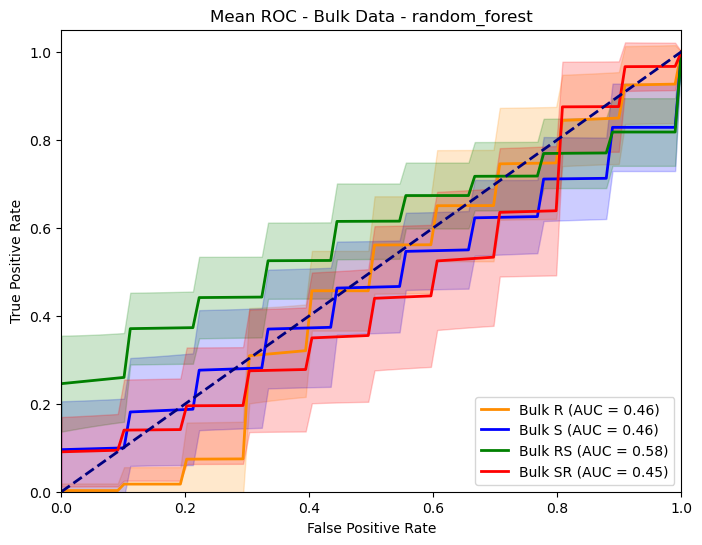

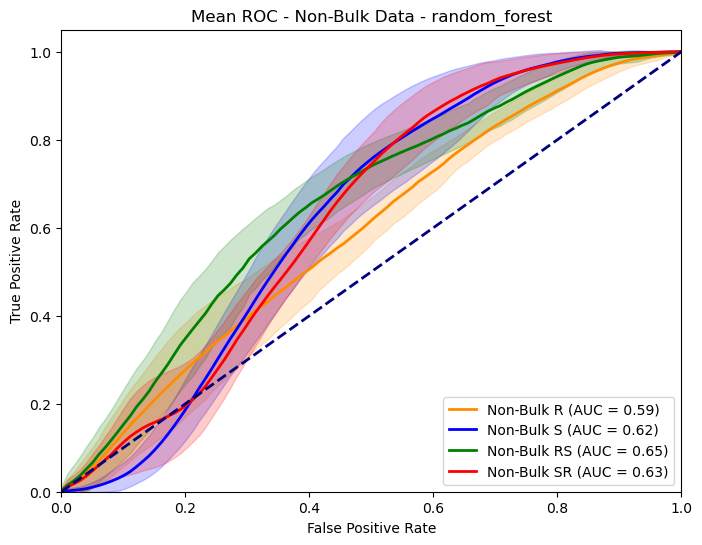

Plotting ROC AUC curves for random_forest with median aggregation


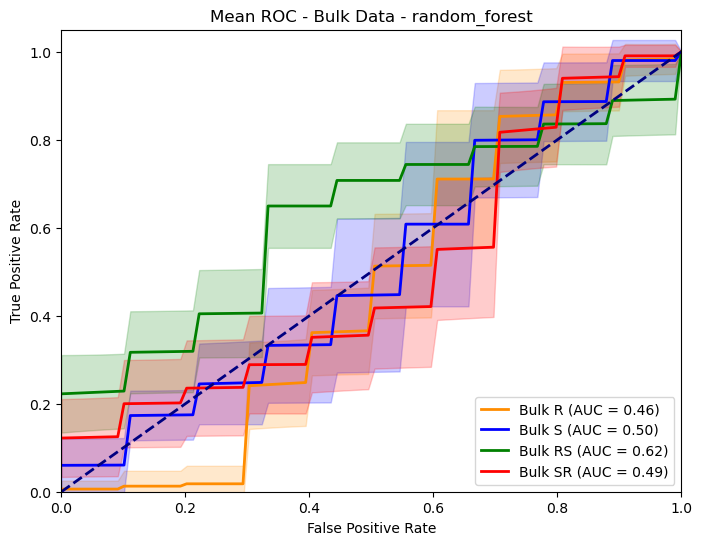

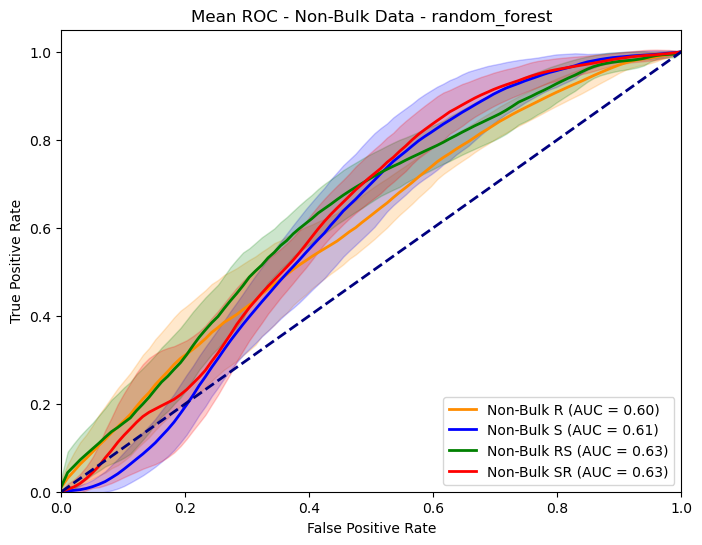

Plotting ROC AUC curves for random_forest with max aggregation


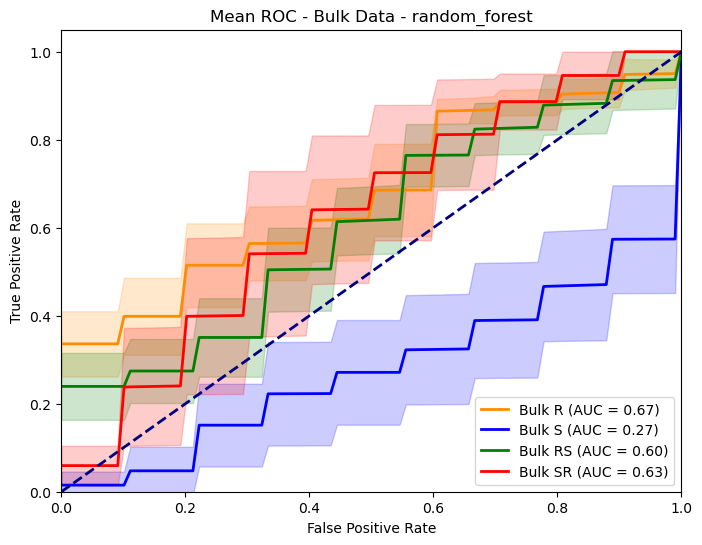

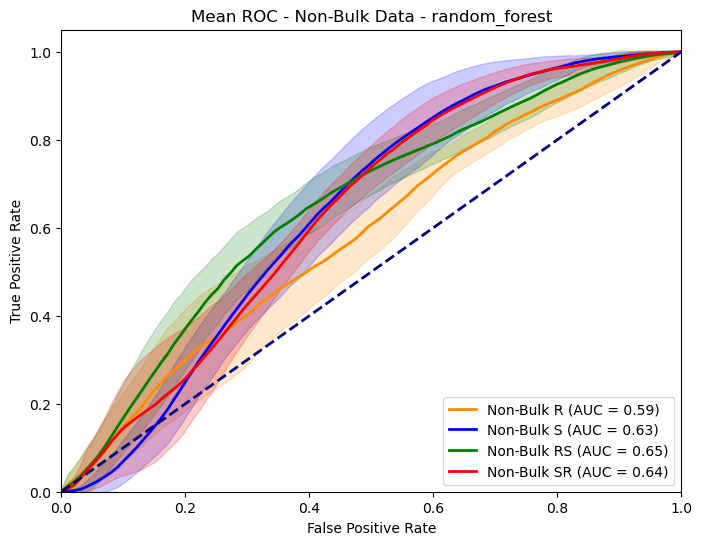

Plotting ROC AUC curves for random_forest with min aggregation


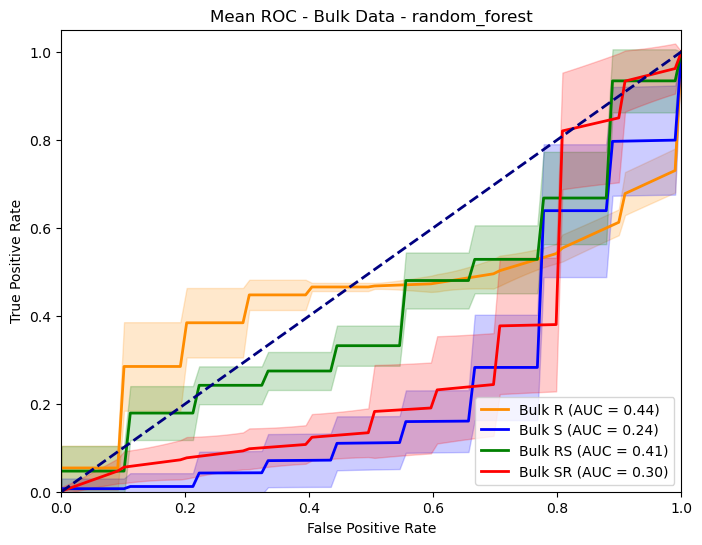

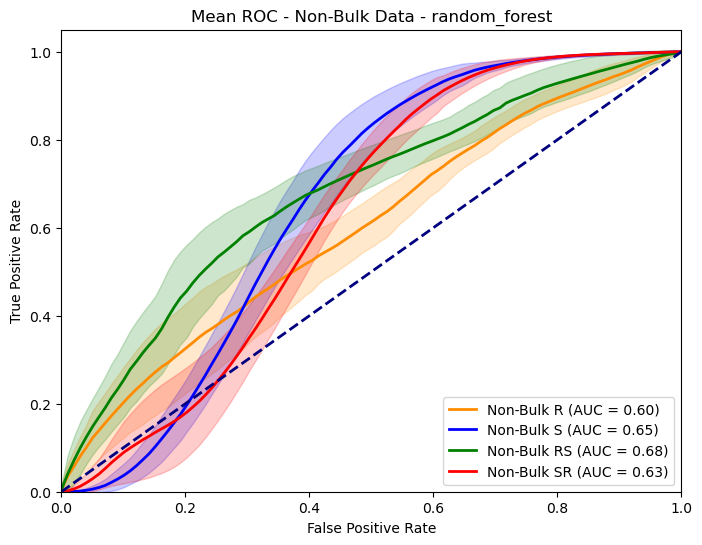

In [6]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_auc_for_model_type(
    model_type: str, agg_func: str, output_dir: Path,
    who_grades_bulk_r: np.ndarray, who_grades_bulk_s: np.ndarray,
    who_grades_r: np.ndarray, who_grades_s: np.ndarray
) -> None:
    """
    Function to plot ROC AUC curves for each model type by reading saved data.

    Args:
      model_type (str): The type of model used for classification.
      agg_func (str): The aggregation function used for the model.
      output_dir (Path): Path to the output directory containing saved results.
      who_grades_bulk_r (np.ndarray): WHO grades for bulk data (replica).
      who_grades_bulk_s (np.ndarray): WHO grades for bulk data (section).
      who_grades_r (np.ndarray): WHO grades for non-bulk data (replica).
      who_grades_s (np.ndarray): WHO grades for non-bulk data (section).

    """
    # Define paths for the saved probabilities and best parameters
    model_output_dir = output_dir / model_type / agg_func
    # Initialize lists to store true labels and predictions
    y_true_bulk_r = (who_grades_bulk_r > 2).astype(int)
    y_true_bulk_s = (who_grades_bulk_s > 2).astype(int)
    y_true_r = (who_grades_r > 2).astype(int)
    y_true_s = (who_grades_s > 2).astype(int)
    # Define arrays to store interpolated TPR values for each seed
    fpr_range = np.linspace(0, 1, 100)
    tprs_bulk_r, tprs_bulk_s, tprs_bulk_rs, tprs_bulk_sr = [], [], [], []
    tprs_r, tprs_s, tprs_rs, tprs_sr = [], [], [], []
    aucs_bulk_r, aucs_bulk_s, aucs_bulk_rs, aucs_bulk_sr = [], [], [], []
    aucs_r, aucs_s, aucs_rs, aucs_sr = [], [], [], []
    # Loop through each seed and load the saved predictions
    for seed_dir in model_output_dir.glob("seed_*"):
        # Load predicted probabilities
        pred_bulk_r = np.load(seed_dir / "predicted_probabilities_bulk_r.npy")
        pred_bulk_s = np.load(seed_dir / "predicted_probabilities_bulk_s.npy")
        pred_bulk_rs = np.load(seed_dir / "predicted_probabilities_bulk_rs.npy")
        pred_bulk_sr = np.load(seed_dir / "predicted_probabilities_bulk_sr.npy")
        pred_r = np.load(seed_dir / "predicted_probabilities_r.npy")
        pred_s = np.load(seed_dir / "predicted_probabilities_s.npy")
        pred_rs = np.load(seed_dir / "predicted_probabilities_rs.npy")
        pred_sr = np.load(seed_dir / "predicted_probabilities_sr.npy")
        # Calculate ROC curves for each category
        fpr_br, tpr_br, _ = roc_curve(y_true_bulk_r, pred_bulk_r)
        fpr_bs, tpr_bs, _ = roc_curve(y_true_bulk_s, pred_bulk_s)
        fpr_brs, tpr_brs, _ = roc_curve(y_true_bulk_s, pred_bulk_rs)
        fpr_bsr, tpr_bsr, _ = roc_curve(y_true_bulk_r, pred_bulk_sr)
        fpr_r, tpr_r, _ = roc_curve(y_true_r, pred_r)
        fpr_s, tpr_s, _ = roc_curve(y_true_s, pred_s)
        fpr_rs, tpr_rs, _ = roc_curve(y_true_s, pred_rs)
        fpr_sr, tpr_sr, _ = roc_curve(y_true_r, pred_sr)

        # Calculate AUC scores directly using roc_auc_score
        aucs_bulk_r.append(roc_auc_score(y_true_bulk_r, pred_bulk_r))
        aucs_bulk_s.append(roc_auc_score(y_true_bulk_s, pred_bulk_s))
        aucs_bulk_rs.append(roc_auc_score(y_true_bulk_s, pred_bulk_rs))
        aucs_bulk_sr.append(roc_auc_score(y_true_bulk_r, pred_bulk_sr))
        aucs_r.append(roc_auc_score(y_true_r, pred_r))
        aucs_s.append(roc_auc_score(y_true_s, pred_s))
        aucs_rs.append(roc_auc_score(y_true_s, pred_rs))
        aucs_sr.append(roc_auc_score(y_true_r, pred_sr))

        # Interpolate TPR values to ensure consistency across different FPR values
        tprs_bulk_r.append(np.interp(fpr_range, fpr_br, tpr_br))
        tprs_bulk_s.append(np.interp(fpr_range, fpr_bs, tpr_bs))
        tprs_bulk_rs.append(np.interp(fpr_range, fpr_brs, tpr_brs))
        tprs_bulk_sr.append(np.interp(fpr_range, fpr_bsr, tpr_bsr))
        tprs_r.append(np.interp(fpr_range, fpr_r, tpr_r))
        tprs_s.append(np.interp(fpr_range, fpr_s, tpr_s))
        tprs_rs.append(np.interp(fpr_range, fpr_rs, tpr_rs))
        tprs_sr.append(np.interp(fpr_range, fpr_sr, tpr_sr))

    # Calculate the mean and standard deviation of TPR values
    def calculate_mean_std(tprs, aucs):
        return np.mean(tprs, axis=0), np.std(tprs, axis=0), np.mean(aucs)

    mean_tpr_br, std_tpr_br, mean_auc_br = calculate_mean_std(tprs_bulk_r, aucs_bulk_r)
    mean_tpr_bs, std_tpr_bs, mean_auc_bs = calculate_mean_std(tprs_bulk_s, aucs_bulk_s)
    mean_tpr_brs, std_tpr_brs, mean_auc_brs = calculate_mean_std(tprs_bulk_rs, aucs_bulk_rs)
    mean_tpr_bsr, std_tpr_bsr, mean_auc_bsr = calculate_mean_std(tprs_bulk_sr, aucs_bulk_sr)
    mean_tpr_r, std_tpr_r, mean_auc_r = calculate_mean_std(tprs_r, aucs_r)
    mean_tpr_s, std_tpr_s, mean_auc_s = calculate_mean_std(tprs_s, aucs_s)
    mean_tpr_rs, std_tpr_rs, mean_auc_rs = calculate_mean_std(tprs_rs, aucs_rs)
    mean_tpr_sr, std_tpr_sr, mean_auc_sr = calculate_mean_std(tprs_sr, aucs_sr)

    # Plot the mean ROC curve with shaded standard deviation area for bulk data
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_range, mean_tpr_br, color='darkorange', lw=2, 
             label=f'Bulk R (AUC = {mean_auc_br:.2f})')
    plt.fill_between(fpr_range, mean_tpr_br - std_tpr_br, mean_tpr_br + std_tpr_br, 
                     color='darkorange', alpha=0.2)
    plt.plot(fpr_range, mean_tpr_bs, color='blue', lw=2, 
             label=f'Bulk S (AUC = {mean_auc_bs:.2f})')
    plt.fill_between(fpr_range, mean_tpr_bs - std_tpr_bs, mean_tpr_bs + std_tpr_bs, 
                     color='blue', alpha=0.2)
    plt.plot(fpr_range, mean_tpr_brs, color='green', lw=2, 
             label=f'Bulk RS (AUC = {mean_auc_brs:.2f})')
    plt.fill_between(fpr_range, mean_tpr_brs - std_tpr_brs, mean_tpr_brs + std_tpr_brs, 
                     color='green', alpha=0.2)
    plt.plot(fpr_range, mean_tpr_bsr, color='red', lw=2, 
             label=f'Bulk SR (AUC = {mean_auc_bsr:.2f})')
    plt.fill_between(fpr_range, mean_tpr_bsr - std_tpr_bsr, mean_tpr_bsr + std_tpr_bsr, 
                     color='red', alpha=0.2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Mean ROC - Bulk Data - {model_type}')
    plt.legend(loc='lower right')
    plt.show()

    # Plot the mean ROC curve with shaded standard deviation area for non-bulk data
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_range, mean_tpr_r, color='darkorange', lw=2, 
             label=f'Non-Bulk R (AUC = {mean_auc_r:.2f})')
    plt.fill_between(fpr_range, mean_tpr_r - std_tpr_r, mean_tpr_r + std_tpr_r, 
                     color='darkorange', alpha=0.2)
    plt.plot(fpr_range, mean_tpr_s, color='blue', lw=2, 
             label=f'Non-Bulk S (AUC = {mean_auc_s:.2f})')
    plt.fill_between(fpr_range, mean_tpr_s - std_tpr_s, mean_tpr_s + std_tpr_s, 
                     color='blue', alpha=0.2)
    plt.plot(fpr_range, mean_tpr_rs, color='green', lw=2, 
             label=f'Non-Bulk RS (AUC = {mean_auc_rs:.2f})')
    plt.fill_between(fpr_range, mean_tpr_rs - std_tpr_rs, mean_tpr_rs + std_tpr_rs, 
                     color='green', alpha=0.2)
    plt.plot(fpr_range, mean_tpr_sr, color='red', lw=2, 
             label=f'Non-Bulk SR (AUC = {mean_auc_sr:.2f})')
    plt.fill_between(fpr_range, mean_tpr_sr - std_tpr_sr, mean_tpr_sr + std_tpr_sr, 
                     color='red', alpha=0.2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Mean ROC - Non-Bulk Data - {model_type}')
    plt.legend(loc='lower right')
    plt.show()

# Define output directory path and model types
output_path = FIGURES_PATH / "classification"
model_types = ['logistic_regression', 'random_forest', 'xgboost', 'lightgbm']
model_types = ['random_forest']
agg_funcs = ['mean', 'median', 'max', 'min']

#
# Get the processed files
processed_files = list(Path(PROCESSED_DATA).iterdir())

# Load the data
(
    spectras, file_names, sample_file_names, sample_numbers, sample_types,
    who_grades
) = load_data(processed_files, metadata_df)
# Convert to bulk
(
    spectras_bulk, file_names_bulk, sample_file_names_bulk,
    sample_numbers_bulk, sample_types_bulk, who_grades_bulk
) = convert_to_bulk(
      spectras, file_names, sample_file_names, sample_numbers, sample_types,
      who_grades
  )

# Iterate through each model type and generate the ROC AUC plots
for model_type in tqdm(model_types):
    for agg_func in agg_funcs:
      print(f"Plotting ROC AUC curves for {model_type} with {agg_func} aggregation")
      plot_roc_auc_for_model_type(
          model_type, agg_func, output_path,
          who_grades_bulk[sample_types_bulk == "replica"], who_grades_bulk[sample_types_bulk == "section"], who_grades[sample_types == "replica"],  who_grades[sample_types == "section"]
      )

Loading data:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Plotting ROC AUC curves for logistic_regression


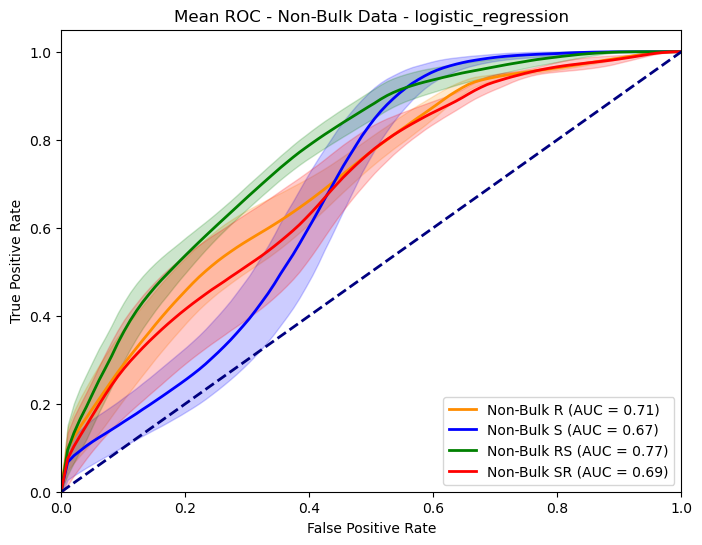

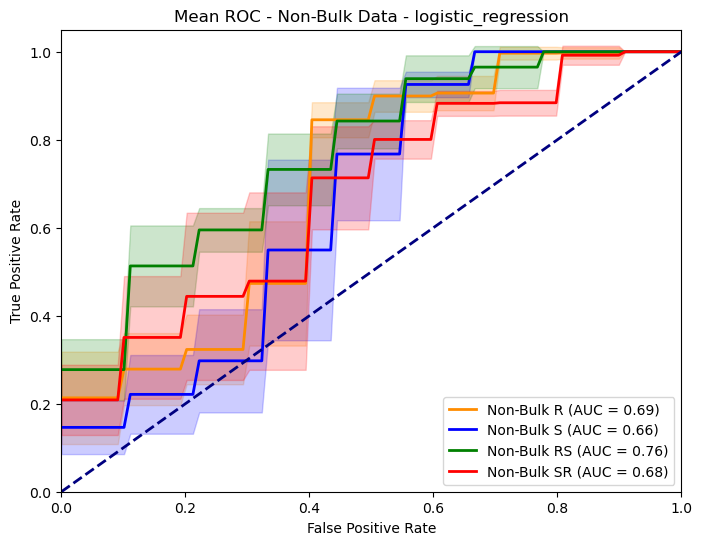

Plotting ROC AUC curves for decision_tree


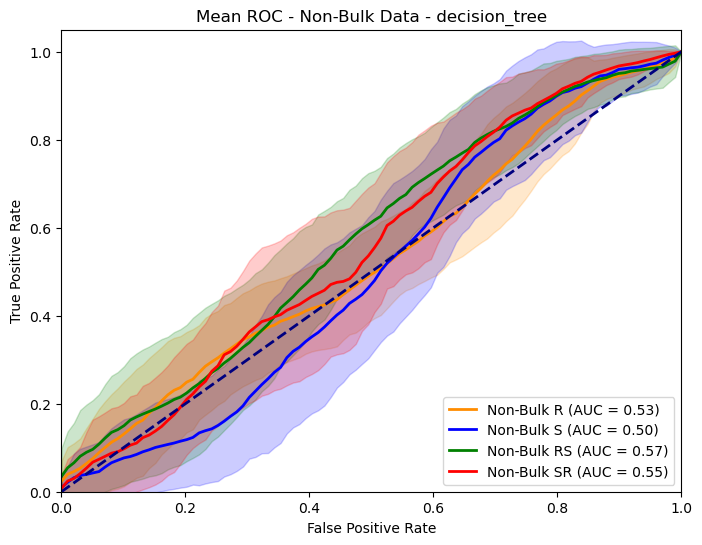

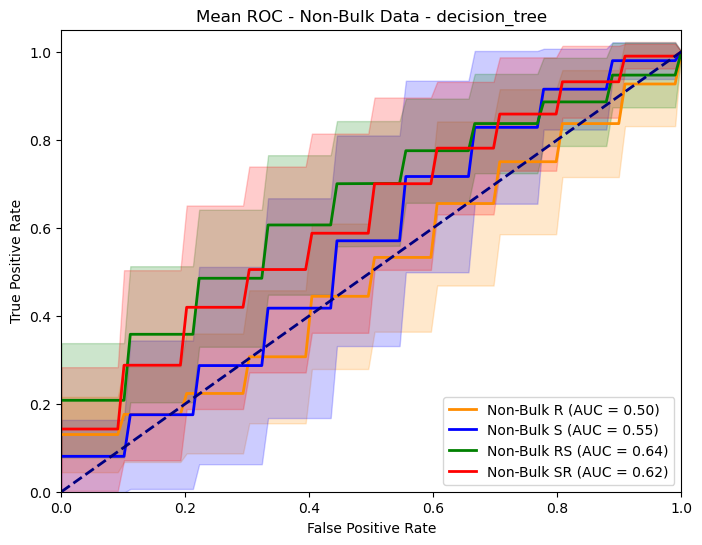

In [32]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_auc_for_model_type(
    model_type: str, output_dir: Path,
    who_grades_r: np.ndarray, who_grades_s: np.ndarray,
    sample_file_names_r: np.ndarray, sample_file_names_s: np.ndarray
) -> None:
    """
    Function to plot ROC AUC curves for each model type by reading saved data.

    Args:
      model_type (str): The type of model used for classification.
      output_dir (Path): Path to the output directory containing saved results.
      who_grades_r (np.ndarray): WHO grades for non-bulk data (replica).
      who_grades_s (np.ndarray): WHO grades for non-bulk data (section).
      sample_file_names_r (np.ndarray): Sample file names for non-bulk data (replica).
      sample_file_names_s (np.ndarray): Sample file names for non-bulk data (section).

    """
    # Define paths for the saved probabilities and best parameters
    model_output_dir = output_dir / model_type / "no_bulk"
    # Prepare grouped indices for non-bulk data
    grouped_indices_r = prepare_grouped_indices(sample_file_names_r)
    grouped_indices_s = prepare_grouped_indices(sample_file_names_s)
    # Initialize lists to store true labels and predictions
    y_true_r = (who_grades_r > 2).astype(int)
    y_true_s = (who_grades_s > 2).astype(int)
    # Group the true labels by sample file names
    group_y_true_r = np.array([
        y_true_r[indices][0] for indices in grouped_indices_r.values()
    ])
    group_y_true_s = np.array([
        y_true_s[indices][0] for indices in grouped_indices_s.values()
    ])
    # Define arrays to store interpolated TPR values for each seed
    fpr_range = np.linspace(0, 1, 100)
    tprs_r, tprs_s, tprs_rs, tprs_sr = [], [], [], []
    aucs_r, aucs_s, aucs_rs, aucs_sr = [], [], [], []
    group_tprs_r, group_tprs_s, group_tprs_rs, group_tprs_sr = [], [], [], []
    group_aucs_r, group_aucs_s, group_aucs_rs, group_aucs_sr = [], [], [], []

    def filter_significant_probabilities(probabilities):
        filtered_probabilities = [p for p in probabilities if p >= 0.5 or p <= 0.5]
        if len(filtered_probabilities) == 0:
            return probabilities
        return filtered_probabilities
    
    # Loop through each seed and load the saved predictions
    for seed_dir in model_output_dir.glob("seed_*"):
        if len(list(seed_dir.glob("*.npy"))) == 0:
            continue
        # Load predicted probabilities
        pred_r = np.load(seed_dir / "predicted_probabilities_r.npy")
        pred_s = np.load(seed_dir / "predicted_probabilities_s.npy")
        pred_rs = np.load(seed_dir / "predicted_probabilities_rs.npy")
        pred_sr = np.load(seed_dir / "predicted_probabilities_sr.npy")
        # Group the predictions by sample file names
        group_preds_r = np.array([
            np.mean(filter_significant_probabilities(pred_r[indices])) for indices in grouped_indices_r.values()
        ])
        group_preds_s = np.array([
            np.mean(filter_significant_probabilities(pred_s[indices])) for indices in grouped_indices_s.values()
        ])
        group_preds_rs = np.array([
            np.mean(filter_significant_probabilities(pred_rs[indices])) for indices in grouped_indices_s.values()
        ])
        group_preds_sr = np.array([
            np.mean(filter_significant_probabilities(pred_sr[indices])) for indices in grouped_indices_r.values()
        ])
        # Calculate ROC curves for each category
        fpr_r, tpr_r, _ = roc_curve(y_true_r, pred_r)
        fpr_s, tpr_s, _ = roc_curve(y_true_s, pred_s)
        fpr_rs, tpr_rs, _ = roc_curve(y_true_s, pred_rs)
        fpr_sr, tpr_sr, _ = roc_curve(y_true_r, pred_sr)
        group_fpr_r, group_tpr_r, _ = roc_curve(group_y_true_r, group_preds_r)
        group_fpr_s, group_tpr_s, _ = roc_curve(group_y_true_s, group_preds_s)
        group_fpr_rs, group_tpr_rs, _ = roc_curve(group_y_true_s, group_preds_rs)
        group_fpr_sr, group_tpr_sr, _ = roc_curve(group_y_true_r, group_preds_sr)

        # Calculate AUC scores directly using roc_auc_score
        aucs_r.append(roc_auc_score(y_true_r, pred_r))
        aucs_s.append(roc_auc_score(y_true_s, pred_s))
        aucs_rs.append(roc_auc_score(y_true_s, pred_rs))
        aucs_sr.append(roc_auc_score(y_true_r, pred_sr))
        group_aucs_r.append(roc_auc_score(group_y_true_r, group_preds_r))
        group_aucs_s.append(roc_auc_score(group_y_true_s, group_preds_s))
        group_aucs_rs.append(roc_auc_score(group_y_true_s, group_preds_rs))
        group_aucs_sr.append(roc_auc_score(group_y_true_r, group_preds_sr))

        # Interpolate TPR values to ensure consistency across different FPR values
        tprs_r.append(np.interp(fpr_range, fpr_r, tpr_r))
        tprs_s.append(np.interp(fpr_range, fpr_s, tpr_s))
        tprs_rs.append(np.interp(fpr_range, fpr_rs, tpr_rs))
        tprs_sr.append(np.interp(fpr_range, fpr_sr, tpr_sr))
        group_tprs_r.append(np.interp(fpr_range, group_fpr_r, group_tpr_r))
        group_tprs_s.append(np.interp(fpr_range, group_fpr_s, group_tpr_s))
        group_tprs_rs.append(np.interp(fpr_range, group_fpr_rs, group_tpr_rs))
        group_tprs_sr.append(np.interp(fpr_range, group_fpr_sr, group_tpr_sr))

    # Calculate the mean and standard deviation of TPR values
    def calculate_mean_std(tprs, aucs):
        return np.mean(tprs, axis=0), np.std(tprs, axis=0), np.mean(aucs)

    mean_tpr_r, std_tpr_r, mean_auc_r = calculate_mean_std(tprs_r, aucs_r)
    mean_tpr_s, std_tpr_s, mean_auc_s = calculate_mean_std(tprs_s, aucs_s)
    mean_tpr_rs, std_tpr_rs, mean_auc_rs = calculate_mean_std(tprs_rs, aucs_rs)
    mean_tpr_sr, std_tpr_sr, mean_auc_sr = calculate_mean_std(tprs_sr, aucs_sr)
    mean_group_tpr_r, std_group_tpr_r, mean_group_auc_r = calculate_mean_std(group_tprs_r, group_aucs_r)
    mean_group_tpr_s, std_group_tpr_s, mean_group_auc_s = calculate_mean_std(group_tprs_s, group_aucs_s)
    mean_group_tpr_rs, std_group_tpr_rs, mean_group_auc_rs = calculate_mean_std(group_tprs_rs, group_aucs_rs)
    mean_group_tpr_sr, std_group_tpr_sr, mean_group_auc_sr = calculate_mean_std(group_tprs_sr, group_aucs_sr)

    # Plot the mean ROC curve with shaded standard deviation area for non-bulk data
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_range, mean_tpr_r, color='darkorange', lw=2, 
             label=f'Non-Bulk R (AUC = {mean_auc_r:.2f})')
    plt.fill_between(fpr_range, mean_tpr_r - std_tpr_r, mean_tpr_r + std_tpr_r, 
                     color='darkorange', alpha=0.2)
    plt.plot(fpr_range, mean_tpr_s, color='blue', lw=2, 
             label=f'Non-Bulk S (AUC = {mean_auc_s:.2f})')
    plt.fill_between(fpr_range, mean_tpr_s - std_tpr_s, mean_tpr_s + std_tpr_s, 
                     color='blue', alpha=0.2)
    plt.plot(fpr_range, mean_tpr_rs, color='green', lw=2, 
             label=f'Non-Bulk RS (AUC = {mean_auc_rs:.2f})')
    plt.fill_between(fpr_range, mean_tpr_rs - std_tpr_rs, mean_tpr_rs + std_tpr_rs, 
                     color='green', alpha=0.2)
    plt.plot(fpr_range, mean_tpr_sr, color='red', lw=2, 
             label=f'Non-Bulk SR (AUC = {mean_auc_sr:.2f})')
    plt.fill_between(fpr_range, mean_tpr_sr - std_tpr_sr, mean_tpr_sr + std_tpr_sr, 
                     color='red', alpha=0.2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Mean ROC - Non-Bulk Data - {model_type}')
    plt.legend(loc='lower right')
    plt.show()

    # Plot the mean ROC curve with shaded standard deviation area for non-bulk data
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_range, mean_group_tpr_r, color='darkorange', lw=2, 
             label=f'Non-Bulk R (AUC = {mean_group_auc_r:.2f})')
    plt.fill_between(fpr_range, mean_group_tpr_r - std_group_tpr_r, mean_group_tpr_r + std_group_tpr_r, 
                     color='darkorange', alpha=0.2)
    plt.plot(fpr_range, mean_group_tpr_s, color='blue', lw=2,
              label=f'Non-Bulk S (AUC = {mean_group_auc_s:.2f})')
    plt.fill_between(fpr_range, mean_group_tpr_s - std_group_tpr_s, mean_group_tpr_s + std_group_tpr_s, 
                     color='blue', alpha=0.2)
    plt.plot(fpr_range, mean_group_tpr_rs, color='green', lw=2,
              label=f'Non-Bulk RS (AUC = {mean_group_auc_rs:.2f})')
    plt.fill_between(fpr_range, mean_group_tpr_rs - std_group_tpr_rs, mean_group_tpr_rs + std_group_tpr_rs, 
                     color='green', alpha=0.2)
    plt.plot(fpr_range, mean_group_tpr_sr, color='red', lw=2,
              label=f'Non-Bulk SR (AUC = {mean_group_auc_sr:.2f})')
    plt.fill_between(fpr_range, mean_group_tpr_sr - std_group_tpr_sr, mean_group_tpr_sr + std_group_tpr_sr, 
                     color='red', alpha=0.2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Mean ROC - Non-Bulk Data - {model_type}')
    plt.legend(loc='lower right')
    plt.show()

# Define output directory path and model types
output_path = FIGURES_PATH / "classification"
model_types = ['logistic_regression', 'random_forest', 'xgboost', 'lightgbm']
model_types = ['logistic_regression', 'decision_tree']

# Get the processed files
processed_files = list(Path(PROCESSED_DATA).iterdir())

# Load the data
(
    spectras, file_names, sample_file_names, sample_numbers, sample_types,
    who_grades
) = load_data(processed_files, metadata_df)

# Iterate through each model type and generate the ROC AUC plots
for model_type in tqdm(model_types):
    print(f"Plotting ROC AUC curves for {model_type}")
    plot_roc_auc_for_model_type(
        model_type, output_path,
        who_grades[sample_types == "replica"],  who_grades[sample_types == "section"],
        sample_file_names[sample_types == "replica"], sample_file_names[sample_types == "section"]
    )

In [9]:
# Prepare grouped indices
grouped_indices = prepare_grouped_indices(sample_file_names)
# Loop over each group for training and testing
for idx, (_, test_idx) in tqdm(
    enumerate(grouped_indices.items()), total=len(grouped_indices),
    desc="LOOCV"
):
  print(test_idx)

LOOCV:   0%|          | 0/50 [00:00<?, ?it/s]

[73347 73348 73349 ... 75900 75901 75902]
[68205 68206 68207 ... 69967 69968 69969]
[30817 30818 30819 ... 33017 33018 33019]
[67237 67238 67239 67240 67241 67242 67243 67244 67245 67246 67247 67248
 67249 67250 67251 67252 67253 67254 67255 67256 67257 67258 67259 67260
 67261 67262 67263 67264 67265 67266 67267 67268 67269 67270 67271 67272
 67273 67274 67275 67276 67277 67278 67279 67280 67281 67282 67283 67284
 67285 67286 67287 67288 67289 67290 67291 67292 67293 67294 67295 67296
 67297 67298 67299 67300 67301 67302 67303 67304 67305 67306 67307 67308
 67309 67310 67311 67312 67313 67314 67315 67316 67317 67318 67319 67320
 67321 67322 67323 67324 67325 67326 67327 67328 67329 67330 67331 67332
 67333 67334 67335 67336 67337 67338 67339 67340 67341 67342 67343 67344
 67345 67346 67347 67348 67349 67350 67351 67352 67353 67354 67355 67356
 67357 67358 67359 67360 67361 67362 67363 67364 67365 67366 67367 67368
 67369 67370 67371 67372 67373 67374 67375 67376 67377 67378 67379 6738

In [13]:
pred_r = np.load(output_path / 'logistic_regression' / "no_bulk" / "seed_42" / "predicted_probabilities_r.npy")

In [18]:
group_preds_r.shape

(25,)

In [26]:
len(list((FIGURES_PATH / "classification" / "xgboost" / "min").glob("seed_*")))

100

In [31]:
who_grades_bulk[sample_types_bulk == "section"]

array([2, 4, 3, 3, 4, 4, 4, 4, 4, 1, 2, 2, 2, 2, 3, 1, 2, 2, 4, 4, 4, 4,
       4, 3, 3])

In [6]:
for model_type in ["logistic_regression", "random_forest", "xgboost", "lightgbm"]:
  output_path = FIGURES_PATH / "classification" / model_type
  print(len(list(output_path.glob("seed_*"))))

  

100
100
100
100


Loading data:   0%|          | 0/50 [00:00<?, ?it/s]

Converting to bulk:   0%|          | 0/50 [00:00<?, ?it/s]

In [18]:
y_labels = (who_grades_bulk > 2).astype(int)
y_labels_r = 
y_labels_s = y_labels[sample_types_bulk == "section"]

In [16]:
predicted_probabilities_bulk_r = np.load(output_path / "seed_42" / "predicted_probabilities_bulk_r.npy")

In [19]:
auc = roc_auc_score(y_labels_r, predicted_probabilities_bulk_r)
fpr, tpr, _ = roc_curve(y_labels_r, predicted_probabilities_bulk_r)
print(auc)

0.11666666666666667


In [ ]:
for i in [
    predicted_probabilities_r, predicted_probabilities_s,
    predicted_probabilities_rs, predicted_probabilities_sr
]:
  auc = roc_auc_score(who_grades_r > 2, i)
  fpr, tpr, _ = roc_curve(who_grades_r > 2, i)

  print(f"AUC: {auc:.2f}")

In [59]:
predicted_probabilities_r, predicted_probabilities_s, predicted_probabilities_rs, predicted_probabilities_sr

(array([0.44643447, 0.89913079, 0.36863586, 0.7850983 , 0.33170833,
        0.62526824, 0.77678722, 0.76579448, 0.7687746 , 0.87443434,
        0.73179707, 0.92083304, 0.37448173, 0.08774396, 0.33200096,
        0.47037249, 0.29542594, 0.84052174, 0.93582467, 0.89250678,
        0.78499597, 0.66244762, 0.69144168, 0.92068129, 0.94927602]),
 array([0.58822646, 0.84886293, 0.37661226, 0.35062431, 0.90695048,
        0.91878789, 0.64072249, 0.4577502 , 0.72657027, 0.89597763,
        0.42315678, 0.64857543, 0.95622216, 0.32522988, 0.12223562,
        0.42616033, 0.33675092, 0.26875969, 0.94421094, 0.9533298 ,
        0.91686254, 0.68631417, 0.64437924, 0.82135546, 0.87232402]),
 array([0.46871463, 0.82806988, 0.20228698, 0.21765302, 0.56386197,
        0.66864014, 0.40716678, 0.55689663, 0.72082375, 0.67739668,
        0.54880095, 0.29227391, 0.91842111, 0.44403672, 0.21356682,
        0.31452391, 0.54992615, 0.26626506, 0.88292876, 0.95820619,
        0.94997041, 0.43885563, 0.84527406, 

In [61]:
best_params_r

[{'class_weight': None,
  'n_estimators': 83,
  'max_depth': 7,
  'max_features': 'sqrt'},
 {'class_weight': 'balanced_subsample',
  'n_estimators': 110,
  'max_depth': 6,
  'max_features': 'log2'},
 {'class_weight': 'balanced',
  'n_estimators': 79,
  'max_depth': 4,
  'max_features': 'log2'},
 {'class_weight': 'balanced_subsample',
  'n_estimators': 197,
  'max_depth': 5,
  'max_features': 'log2'},
 {'class_weight': 'balanced_subsample',
  'n_estimators': 176,
  'max_depth': 5,
  'max_features': 'log2'},
 {'class_weight': 'balanced',
  'n_estimators': 130,
  'max_depth': 7,
  'max_features': 'log2'},
 {'class_weight': 'balanced_subsample',
  'n_estimators': 194,
  'max_depth': 5,
  'max_features': 'log2'},
 {'class_weight': None,
  'n_estimators': 127,
  'max_depth': 6,
  'max_features': 'sqrt'},
 {'class_weight': 'balanced',
  'n_estimators': 197,
  'max_depth': 6,
  'max_features': None},
 {'class_weight': 'balanced',
  'n_estimators': 109,
  'max_depth': 7,
  'max_features': None}

In [62]:
best_params_s

[{'class_weight': 'balanced',
  'n_estimators': 50,
  'max_depth': 6,
  'max_features': 'log2'},
 {'class_weight': None,
  'n_estimators': 75,
  'max_depth': 4,
  'max_features': 'sqrt'},
 {'class_weight': 'balanced',
  'n_estimators': 83,
  'max_depth': 6,
  'max_features': None},
 {'class_weight': 'balanced',
  'n_estimators': 97,
  'max_depth': 5,
  'max_features': None},
 {'class_weight': 'balanced',
  'n_estimators': 61,
  'max_depth': 3,
  'max_features': None},
 {'class_weight': 'balanced',
  'n_estimators': 63,
  'max_depth': 5,
  'max_features': None},
 {'class_weight': None,
  'n_estimators': 169,
  'max_depth': 7,
  'max_features': 'log2'},
 {'class_weight': 'balanced_subsample',
  'n_estimators': 173,
  'max_depth': 5,
  'max_features': 'log2'},
 {'class_weight': None,
  'n_estimators': 124,
  'max_depth': 3,
  'max_features': 'sqrt'},
 {'class_weight': 'balanced',
  'n_estimators': 56,
  'max_depth': 6,
  'max_features': 'sqrt'},
 {'class_weight': 'balanced_subsample',
  '

In [63]:
for i in [
    predicted_probabilities_r, predicted_probabilities_s,
    predicted_probabilities_rs, predicted_probabilities_sr
]:
  auc = roc_auc_score(who_grades_r > 2, i)
  fpr, tpr, _ = roc_curve(who_grades_r > 2, i)

  print(f"AUC: {auc:.2f}")


AUC: 0.73
AUC: 0.54
AUC: 0.57
AUC: 0.75


In [ ]:
predicted_probabilities_df = pd.DataFrame(
    predicted_probabilities.T, columns=seeds, index=files_names_r
)
predicted_probabilities_df.to_csv(FIGURES_PATH / "predicted_probabilities.csv")

for i in predicted_probabilities:
  auc = roc_auc_score(who_grades_r > 2, i)
  fpr, tpr, _ = roc_curve(who_grades_r > 2, i)

  print(f"AUC: {auc:.2f}")

auc = roc_auc_score(who_grades_r > 2, predicted_probabilities)
fpr, tpr, _ = roc_curve(who_grades_r > 2, predicted_probabilities)

# Plot the ROC curve
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:0.2f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [9]:
# Create mapper from replica to section
r_2_s = {
    '210709-HG1c-r1_TopMax': '210712-HG1c-s2_TopMax',
    '210713-HG9c-10c-r1_TopMax': '210714-HG9c-10c-s3_TopMax',
    '210714-HG12c-11c-r1_TopMax': '210714-HG11cx2-12c-s3_TopMax',
    '210714-HG6cx2-7c-r1_TopMax': '210714-HG6c-7c-s3_TopMax',
    '210715-HG18c-19c-18c-r1_TopMax': '210716-HG19c-18c-s3_TopMax',
    '210903-HG13c-14c-r2_TopMax': '210903-HG13c-14c-s3_TopMax',
    '210904-HG15c-16c-r1_TopMax': '210904-HG15c-16c-s3_TopMax',
    '210906-HG29c-25c-23c-21c-20c-r1_TopMax':
    '210905-HG29c-25c-23c-21c-20c-s3_TopMax', '211003-hg8-5-4-3-2-r1_TopMax':
    '211003-hg8-12-5-4-3-2-s3_TopMax'
}
# Create mapper from section to replica
s_2_r = {v: k for k, v in r_2_s.items()}

Index(['file_name', 'sample_file_name', 'sample_number', 'sample_type',
       'histology', 'who_grade', 'x_min', 'y_min', 'x_max', 'y_max'],
      dtype='object')

In [12]:
files_names = []
means_spectras = []
sample_types = []
who_grades = []
sample_numbers = []

processed_files = list(Path(PROCESSED_DATA).iterdir())

for i, p in tqdm(enumerate(processed_files), total=len(processed_files)):
  # Load the data
  img = np.load(p / "mapped_tic_normalized.npy")
  #
  seg = np.load(p / "segmentation.npy")

  # Get the file name
  files_name = metadata_df[metadata_df.sample_file_name == p.stem
                          ].file_name.values[0]
  files_names.append(files_name)

  # Get the sample type
  sample_type = metadata_df[metadata_df.sample_file_name == p.stem
                           ].sample_type.values[0]
  sample_types.append(sample_type)

  # Get the WHO grade
  who_grade = metadata_df[metadata_df.sample_file_name == p.stem
                         ].who_grade.values[0]
  who_grades.append(who_grade)

  # Get the sample number
  sample_number = metadata_df[metadata_df.sample_file_name == p.stem
                             ].sample_number.values[0]
  sample_numbers.append(sample_number)

  # Calculate the mean of the data
  mean_data = img[seg == 1].mean(axis=0)
  means_spectras.append(mean_data)

# Convert the lists to numpy arrays
files_names = np.array(files_names)
means_spectras = np.array(means_spectras)
sample_types = np.array(sample_types)
who_grades = np.array(who_grades)
sample_numbers = np.array(sample_numbers)

# Split to section and replica
files_names_r = files_names[sample_types == 'replica']
files_names_s = files_names[sample_types == 'section']
means_spectras_r = means_spectras[sample_types == 'replica']
means_spectras_s = means_spectras[sample_types == 'section']
who_grades_r = who_grades[sample_types == 'replica']
who_grades_s = who_grades[sample_types == 'section']
sample_numbers_r = sample_numbers[sample_types == 'replica']
sample_numbers_s = sample_numbers[sample_types == 'section']

  0%|          | 0/50 [00:00<?, ?it/s]

In [92]:
import random
import warnings
import optuna
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from typing import Any
from joblib import Parallel, delayed


def objective(
    trial, model_type: str, X_train: np.ndarray, y_train: np.ndarray,
    batch_ids: np.ndarray, seed: int
) -> float:
  """
    Objective function for Optuna to optimize hyperparameters of a model using 
        cross-validation.

    Args:
      trial (optuna.trial.Trial): A trial object that suggests hyperparameters.
      X_train (np.ndarray): Training feature matrix of shape (n_samples, 
          n_features).
      y_train (np.ndarray): Training target vector of shape (n_samples,).
      batch_ids (np.ndarray): Array of group IDs used to group samples for 
          cross-validation.

    Returns:
      float: The mean AUC score across the cross-validation folds for the 
          suggested hyperparameters.

    """
  # Suggest hyperparameters using Optuna for Logistic Regression
  if model_type == 'logistic_regression':
    C = trial.suggest_float('C', 1e-6, 1e+6, log=True)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    tol = trial.suggest_float('tol', 1e-4, 1e-2, log=True)
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs'])
    model = LogisticRegression(
        C=C, max_iter=max_iter, tol=tol, solver=solver, class_weight='balanced',
        random_state=seed
    )

  # Suggest hyperparameters using Optuna for Decision Tree
  elif model_type == 'decision_tree':
    max_depth = trial.suggest_int('max_depth', 1, 32)
    max_features = trial.suggest_categorical(
        'max_features', ['sqrt', 'log2', None]
    )
    model = DecisionTreeClassifier(
        max_depth=max_depth, max_features=max_features, random_state=seed
    )

  # Suggest hyperparameters using Optuna for Random Forest
  elif model_type == 'random_forest':
    class_weight = trial.suggest_categorical(
        'class_weight', [None, 'balanced', 'balanced_subsample']
    )
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 7)
    max_features = trial.suggest_categorical(
        'max_features', ['sqrt', 'log2', None]
    )
    model = RandomForestClassifier(
        class_weight=class_weight, n_estimators=n_estimators,
        max_depth=max_depth, max_features=max_features, random_state=seed
    )

  # Suggest hyperparameters using Optuna for XGBoost
  elif model_type == 'xgboost':
    max_depth = trial.suggest_int('max_depth', 3, 7)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1, log=True)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
    gamma = trial.suggest_float('gamma', 0, 5)
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    model = XGBClassifier(
        max_depth=max_depth, learning_rate=learning_rate, subsample=subsample,
        colsample_bytree=colsample_bytree, gamma=gamma,
        n_estimators=n_estimators, random_state=seed
    )

  # Suggest hyperparameters using Optuna for LightGBM
  else:
    max_depth = trial.suggest_int('max_depth', 3, 7)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1, log=True)
    num_leaves = trial.suggest_int('num_leaves', 30, 70)
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    model = LGBMClassifier(
        num_leaves=num_leaves, learning_rate=learning_rate,
        n_estimators=n_estimators, max_depth=max_depth, random_state=seed,
        verbose=-1
    )

  # Define cross-validation
  skf = StratifiedGroupKFold(n_splits=3, shuffle=False)

  # Define predictions array
  predictions = np.zeros(y_train.shape)

  # Perform cross-validation with the suggested hyperparameters
  for train_idx, val_idx in skf.split(X_train, y_train, batch_ids):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, _ = y_train[train_idx], y_train[val_idx]
    with warnings.catch_warnings():
      # Suppress specific warnings during hyperparameter tuning
      warnings.simplefilter("ignore", category=ConvergenceWarning)
      model.fit(X_tr, y_tr)
    predictions[val_idx] = model.predict_proba(X_val)[:, 1]

  # Calculate AUC score and return
  return roc_auc_score(y_train, predictions)


# Define the training function that encapsulates the entire process
def single_seed_loocv_train_predict(
    model_type, batch_ids, X, y, patient_ids, seed, n_trials=50, n_jobs=-1
):
  # Set random seed for reproducibility
  np.random.seed(seed)
  random.seed(seed)

  # Prepare grouped indices
  unique_vals, _ = np.unique(batch_ids, return_inverse=True)
  grouped_indices = {val: np.where(batch_ids == val)[0] for val in unique_vals}

  # Array to store predicted grades probabilities
  predicted_probabilities = np.zeros(len(batch_ids))

  # Loop over each image to perform training and testing
  for batch_id, test_idx in grouped_indices.items():
    # Get training indices based on the grouping criteria
    train_idx = ~np.isin(patient_ids, patient_ids[test_idx])

    # Prepare training and test data
    X_train = X[train_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]

    # Hyperparameter tuning with Optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(
        lambda trial: objective(
            trial, model_type, X_train, y_train, batch_ids[train_idx], seed
        ), n_trials=n_trials, n_jobs=n_jobs
    )

    # Train the best model with the best parameters
    best_params = study.best_params
    best_model = RandomForestClassifier(**best_params, random_state=seed)
    best_model.fit(X_train, y_train)

    # Calibration using CalibratedClassifierCV
    calibrated_classifier = CalibratedClassifierCV(
        best_model, method='sigmoid', cv='prefit'
    )
    calibrated_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    predicted_probabilities[test_idx] = calibrated_classifier.predict_proba(
        X_test
    )[:, 1]

  return predicted_probabilities


def multiple_seeds_loocv_train_predict(
    primary_seed, iterations, model_type, batch_ids, X, y, patient_ids,
    n_trials=50, n_jobs=-1
):
  # Set the primary seed for reproducibility
  np.random.seed(primary_seed)
  random.seed(primary_seed)

  # Generate multiple seeds for evaluation
  evaluation_seeds = [primary_seed] + [
      int(i) for i in
      np.random.choice(range(10000), size=iterations - 1, replace=False)
  ]

  # Perform LOOCV with multiple seeds
  results = [
      r for r in tqdm(
          Parallel(return_as="generator", n_jobs=n_jobs)(
              delayed(single_seed_loocv_train_predict)(
                  model_type, batch_ids, X, y, patient_ids, seed, n_trials,
                  n_jobs
              ) for seed in evaluation_seeds
          ), total=len(evaluation_seeds), desc="LOOCV with Multiple Seeds"
      )
  ]

  # Return the results
  return evaluation_seeds, np.array(results)


primary_seed = 42
model_type = 'random_forest'
n_iterations = 10
# Train on replica samples
seeds_r, predicted_probabilities_r = multiple_seeds_loocv_train_predict(
    primary_seed, n_iterations, model_type, files_names_r, means_spectras_r,
    (who_grades_r > 2).astype(int), sample_numbers_r
)
# Train on section samples
seeds_s, predicted_probabilities_s = multiple_seeds_loocv_train_predict(
    primary_seed, n_iterations, model_type, files_names_s, means_spectras_s,
    (who_grades_s > 2).astype(int), sample_numbers_s
)
# Create mapper from replica to section
r_2_s = {
    'HG 12-11-r': "HG 11-11-12-s", 'HG 14-13-r': "HG 14-13-s", 'HG 16-15-r':
    "HG 16-15-s", 'HG 18-19-18-r': "HG 19-18-s", 'HG 29-25-23-21-20-r':
    "HG 29-25-23-21-20-s", 'HG 6-6-7-r': "HG 6-7-s", 'HG 8-5-4-3-2-r':
    "HG 8-12-5-4-3-2-s", 'HG 9-10-r': "HG 9-10-s", 'HG 1-r': "HG 1-s"
}
# Create mapper from section to replica
s_2_r = {v: k for k, v in r_2_s.items()}

LOOCV with Multiple Seeds:   0%|          | 0/10 [00:00<?, ?it/s]

[I 2024-10-25 18:13:15,531] A new study created in memory with name: no-name-47528c6a-d763-4c24-be21-062bba859fbf
[I 2024-10-25 18:13:15,531] A new study created in memory with name: no-name-f4186c01-0686-4aae-9115-c09fa782a37f
[I 2024-10-25 18:13:15,531] A new study created in memory with name: no-name-1c78a1c3-baa1-45da-b6c7-830b7861a7f8
[I 2024-10-25 18:13:15,531] A new study created in memory with name: no-name-41362bd6-3c7c-4e6e-9726-5b3fdc5a897b
[I 2024-10-25 18:13:35,081] Trial 7 finished with value: 0.4481481481481482 and parameters: {'class_weight': None, 'n_estimators': 50, 'max_depth': 7, 'max_features': 'log2'}. Best is trial 7 with value: 0.4481481481481482.
[I 2024-10-25 18:13:35,984] Trial 1 finished with value: 0.5407407407407407 and parameters: {'class_weight': None, 'n_estimators': 59, 'max_depth': 3, 'max_features': 'log2'}. Best is trial 1 with value: 0.5407407407407407.
[I 2024-10-25 18:13:36,900] Trial 8 finished with value: 0.4740740740740741 and parameters: {'cl

In [ ]:
###################################################

In [76]:
import sys

sys.path.append(".")

from binary_classifier_trainer import BinaryClassifierTrainer

n_iterations = 1
n_permutations = 1
model_type = "logistic_regression"
tune_hyperparameters = False

X = means_spectras_r.copy()
y = who_grades_r > 2

# Initialize the BinaryClassifierTrainer
trainer = BinaryClassifierTrainer(
    X, y, files_names_r, n_iterations, n_permutations, model_type=model_type,
    sample_ids=files_names_r, tune_hyperparameters=tune_hyperparameters
)

save_dir = Path(".") / "classification_results_replica"
save_dir.mkdir(parents=True, exist_ok=True)
trainer.run(save_dir)

LOOCV with Multiple Seeds: 100%|██████████| 1/1 [00:03<00:00,  3.05s/it]


Seed: 42, AUC: 0.5533
Best Seed: 42, Best AUC: 0.5533


Permutation Test: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


In [77]:
X = means_spectras_s.copy()
y = who_grades_s > 2

# Initialize the BinaryClassifierTrainer
trainer = BinaryClassifierTrainer(
    X, y, files_names_s, n_iterations, n_permutations, model_type=model_type,
    sample_ids=files_names_s, tune_hyperparameters=tune_hyperparameters
)

save_dir = Path(".") / "classification_results_section"
save_dir.mkdir(parents=True, exist_ok=True)
trainer.run(save_dir)

LOOCV with Multiple Seeds: 100%|██████████| 1/1 [00:00<00:00, 16.46it/s]


Seed: 42, AUC: 0.5764
Best Seed: 42, Best AUC: 0.5764


Permutation Test: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


In [ ]:
if args.patch_wise:
    # Process embeddings patch-wise
    X, y, group_ids, leap_ids = process_embeddings_patch_wise(
        csv_files, metadata_df
    )
    # Initialize the BinaryClassifierTrainer
    trainer = BinaryClassifierTrainer(
        X, y, group_ids, args.n_iterations, args.n_permutations,
        model_type=args.model_type, sample_ids=leap_ids, is_mil=True,
        sampling_percentage=args.sampling_percentage,
        tune_hyperparameters=args.tune_hyperparameters
    )

  else:
    # Process embeddings tissue-wise
    X, y, group_ids, leap_ids = process_embeddings_tissue_wise(
        csv_files, metadata_df, args.agg_func
    )
    # Initialize the BinaryClassifierTrainer
    trainer = BinaryClassifierTrainer(
        X, y, group_ids, args.n_iterations, args.n_permutations,
        model_type=args.model_type, sample_ids=leap_ids,
        tune_hyperparameters=args.tune_hyperparameters
    )

  # Run the training, evaluation, and plotting pipeline
  if args.patch_wise:
    save_dir = Path(
        CWD / "classification_results" / args.model_type / "patch_wise"
    )
  else:
    save_dir = Path(
        CWD / "classification_results" / args.model_type / args.agg_func
    )
  save_dir.mkdir(parents=True, exist_ok=True)
  trainer.run(save_dir)


In [79]:
for mz_mapping in mappings:
  print(len(list(filter(lambda x: x is not None, list(mz_mapping.keys())))))

137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137


In [83]:
for idx, (mzs, sample_type) in enumerate(all_mzs):
  mzs = np.array(mzs)
  for mz in mzs:
    if sum(np.abs(mzs - mz) < 0.02) > 1:
      print(idx, mz)

6 644.9775
6 644.988


In [84]:
for i, p in tqdm(enumerate(list(Path(RAW_DATA).iterdir()))):
  if i == 6:
    print(p)

0it [00:00, ?it/s]

../data/DHG/raw_txt/210904-HG15c-16c-r1_TopMax.txt


In [51]:
len(common_mz_values_all)

3020

In [57]:
not_common_mzs = []

for mzs, sample_type in all_mzs:
  for mz in mzs:
    if sum(np.abs(common_mz_values_all - mz) < 0.02) == 0:
      not_common_mzs.append((mz, sample_type))

In [59]:
len(not_common_mzs)

20845

In [ ]:
not_common_mzs

In [56]:
max_mzs = 0
for mzs, sample_type in all_mzs:
  print(len(mzs))
  if len(mzs) > max_mzs:
    max_mzs = len(mzs)
max_mzs

3020
3267
2217
2026
2971
1589
2626
2284
2513
2901
1942
2538
2288
2681
3298
2401
2145
3203


3298

In [31]:
common_mz_values_r = common_mzs(
    *[np.array(mzs) for mzs, sample_type in all_mzs if sample_type == 'r'],
    tolerance=0.02
)
common_mz_values_r

array([794.5527, 885.5541, 600.5136, 795.5546, 768.5353, 766.5394,
       822.5792, 796.5535, 744.5615, 886.5607, 862.6497, 848.6213,
       750.5433, 890.6447, 765.5712, 788.5514, 718.5446, 820.5725,
       682.5891, 821.5702, 792.5543, 889.6378, 842.5402, 778.5566,
       823.5772, 838.5563, 745.5581, 602.5137, 769.537 , 601.5154,
       654.5676, 863.644 , 836.5471, 887.5723, 627.5344, 762.5624,
       789.5634, 764.5425, 751.5515, 849.6249, 774.5577, 770.5389,
       852.5153, 776.5521, 603.4907, 763.5547, 779.5619, 790.5543,
       748.5311, 854.5156, 826.4982, 719.5277, 740.5059, 684.6016,
       715.5821, 777.5471, 797.5518, 853.5174, 857.5231, 626.5355,
       775.5649, 752.5547, 791.5594, 860.6414, 834.542 , 810.5284,
       880.5458, 681.5357, 850.6222, 839.5559, 602.3759, 773.5685,
       818.5463, 827.5014, 687.3477, 628.5391, 683.5936, 814.5643,
       669.4591, 739.5237, 844.5557, 753.5506, 655.5677, 687.561 ,
       811.5261, 633.3994, 647.1249, 631.503 , 855.5174, 843.5

In [32]:
common_mz_values_s = common_mzs(
    *[np.array(mzs) for mzs, sample_type in all_mzs if sample_type == 's'],
    tolerance=0.02
)
common_mz_values_s

array([885.553 , 794.552 , 768.5353, 795.5535, 886.5564, 766.5405,
       600.5125, 822.5785, 796.5515, 767.5411, 744.5603, 821.5669,
       788.549 , 765.5766, 887.5649, 834.5422, 611.1309, 770.5371,
       820.5687, 750.5416, 792.5516, 769.5349, 682.5778, 789.5581,
       849.6121, 745.5528, 852.5158, 836.5431, 718.5444, 823.5783,
       778.5565, 751.5508, 838.5556, 681.5283, 654.5659, 835.5422,
       666.0634, 747.5258, 617.4177, 669.4567, 609.1313, 883.5346,
       653.489 , 826.4965, 825.5049, 890.6394, 810.5272, 764.5343,
       797.5485, 695.5414, 842.5359, 790.5482, 627.4009, 601.5134,
       839.5546, 853.5137, 818.5444, 746.5282, 748.5273, 673.3514,
       603.1102, 607.1339, 603.4782, 762.5461, 854.5129, 774.5509,
       613.3954, 633.1349, 687.3548, 771.5407, 602.5121, 791.5576,
       740.5067, 626.5355, 837.543 , 627.5338, 633.3966, 635.4009,
       722.5092, 880.5408, 603.4017, 645.4522, 719.5243, 763.5411,
       776.5533, 644.0872, 811.5227, 605.1187, 667.0698, 621.1

In [35]:
common_mz_values_all = common_mzs(
    common_mz_values_r, common_mz_values_s, tolerance=0.02
)
common_mz_values_all

133

In [36]:
len(common_mz_values_all), len(common_mz_values_r), len(common_mz_values_s)

(133, 223, 228)

In [21]:
len(common_mz_values)

137

In [61]:
new_all_mzs = []

for mzs in all_mzs:
  new_mzs = []
  for mz in mzs:
    candidates = np.abs(unique_mzs - mz) < MASS_RESOLUTION
    if np.any(candidates):
      new_mz = unique_mzs[np.argmin(np.abs(unique_mzs - mz))]
    else:
      new_mz = mz
    new_mzs.append(new_mz)
  new_all_mzs.append(new_mzs)
  break

In [ ]:
def find_best_starting_order(mz_lists, tolerance=0.02):
  """
    This function takes a list of lists of m/z values, runs the common_mzs function with each list as the starting list,
    and returns the order that yields the most common m/z values.
    
    Parameters:
    mz_lists : list of numpy arrays, where each array contains m/z values
    tolerance : float, the tolerance for closeness in m/z values (default: 0.02)
    
    Returns:
    best_start_list : numpy array, the starting list that yields the most common m/z values
    max_common_mzs : numpy array, the common m/z values for the best starting order
    """

  # Keep track of the best starting list and the maximum common m/z values
  max_common_mzs = np.array([])

  # Iterate over each list to be the starting list
  for i in range(len(mz_lists)):
    # Move the ith list to the front, keeping the rest in the original order
    ordered_lists = [mz_lists[i]] + mz_lists[:i] + mz_lists[i + 1:]

    # Run the common_mzs function with this order
    common_mz_values = find_common_mzs(*ordered_lists, tolerance=tolerance)

    # Update if this starting order yields more common m/z values
    if len(common_mz_values) > len(max_common_mzs):
      max_common_mzs = common_mz_values

  return max_common_mzs


In [ ]:
# OLD

In [5]:
#  Get normalizer object
normalizer = TICNormalizer()
# Get binning object
binning = EqualWidthBinning(MZ_START, MZ_END, MASS_RESOLUTION / 2)

# Loop through the files
for p in Path(RAW_DATA).iterdir():
  # Subset metadata for the current file
  l_metadata_df = metadata_df.loc[metadata_df["file_name"] == p.stem].copy()
  # Get image
  img, mzs = process_spectral_data_to_image(p)
  # Apply binning and normalization
  img_processed = np.apply_along_axis(
      lambda intensities:
      (binning.bin(normalizer.normalize((mzs, intensities))))[1], axis=2,
      arr=img
  )
  # Identify channels that are all zeros
  channel_sums = np.sum(img_processed, axis=(0, 1))
  zero_channels_idx = np.where(channel_sums == 0)[0]
  # Remove the zero channels
  img_processed = np.delete(img_processed, zero_channels_idx, axis=2)
  # Apply segmentation
  mzs = binning.bin_centers[channel_sums != 0]
  segmenter = MeanSegmentation(mzs, REPRESENTATIVE_PEAKS, MASS_RESOLUTION * 4)
  img_segmented = segmenter.segment(img_processed)
  # Apply Z-score correction
  img_norm = ZScoreCorrection().correct(img_processed, img_segmented)
  # Loop through the ROIs
  for index, roi in l_metadata_df.iterrows():
    # Define path to new msi imzML file after processing
    output_path = PROCESSED_DATA / f"{roi.sample_file_name}"
    # Create output folder if doesn't exist
    output_path.mkdir(parents=True, exist_ok=True)
    # Get the ROI coordinates
    x_min, x_max = roi["x_min"], roi["x_max"]
    y_min, y_max = roi["y_min"], roi["y_max"]
    # Get the ROI image
    roi_img = img_processed[y_min:y_max, x_min:x_max, :]
    # Get the ROI normalized image
    roi_img_norm = img_norm[y_min:y_max, x_min:x_max, :]
    # Get the ROI segmented image
    roi_img_segmented = img_segmented[y_min:y_max, x_min:x_max]
    # Save the information
    np.save(output_path / f"common_representation.npy", roi_img)
    np.save(output_path / f"meaningful_signal.npy", roi_img_norm)
    np.save(output_path / f"segmentation.npy", roi_img_segmented)
    np.save(output_path / f"mzs.npy", mzs)

In [6]:
# Define the dictionary to store the mzs values and the number of files they
# appear in
mzs_values_file_count = {}
# Loop through the files
for p in Path(PROCESSED_DATA).iterdir():
  # Get the mzs values
  mzs = np.load(p / "mzs.npy")
  # Loop through the mzs values
  for mz in mzs:
    # Increment the count of the mz value
    mzs_values_file_count[mz] = mzs_values_file_count.get(mz, 0) + 1
# Get the unique mzs values
unique_mzs = np.array(sorted(list(mzs_values_file_count.keys())))

In [9]:
# Loop through the files
for p in Path(PROCESSED_DATA).iterdir():
  # Get the mzs values
  mzs = np.load(p / "mzs.npy")
  # Get the common representation image
  img = np.load(p / "common_representation.npy")
  # Get the meaningful signal image
  img_norm = np.load(p / "meaningful_signal.npy")
  #
  all_data_mzs = np.concatenate([mzs, np.setdiff1d(unique_mzs, mzs)])
  #
  sorted_mz_indices = np.argsort(all_data_mzs)
  #
  new_img = np.zeros((img.shape[0], img.shape[1], unique_mzs.shape[0]))
  new_img_norm = np.zeros(
      (img_norm.shape[0], img_norm.shape[1], unique_mzs.shape[0])
  )
  #
  new_img[:, :, :img.shape[-1]] = img
  new_img_norm[:, :, :img_norm.shape[-1]] = img_norm
  #
  sorted_mzs_img = new_img[:, :, sorted_mz_indices]
  sorted_mzs_img_norm = new_img_norm[:, :, sorted_mz_indices]
  #
  np.save(output_path / f"common_representation_all_mzs.npy", sorted_mzs_img)
  np.save(output_path / f"meaningful_signal_all_mzs.npy", sorted_mzs_img_norm)
  np.save(output_path / f"mzs.npy", all_data_mzs[sorted_mz_indices])

  break

In [ ]:
# Temp validation

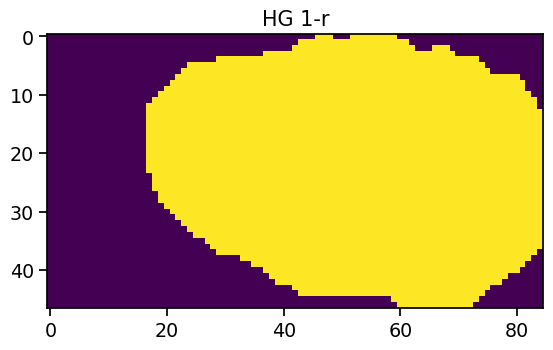

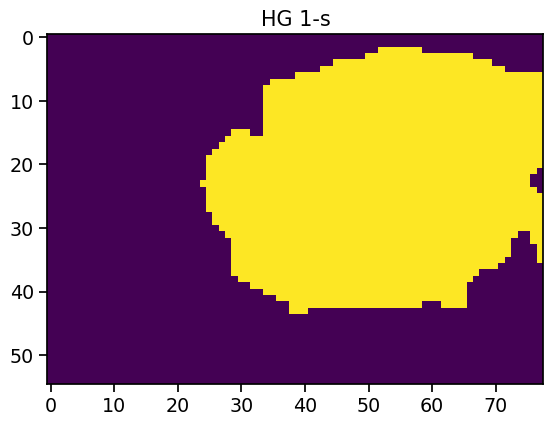

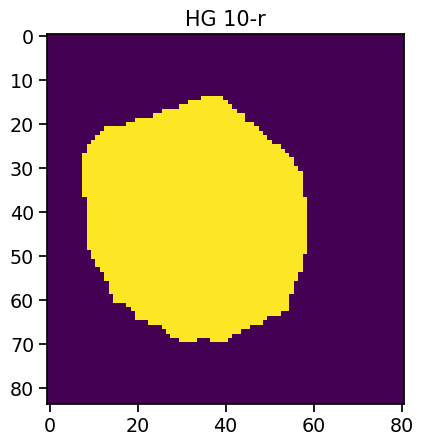

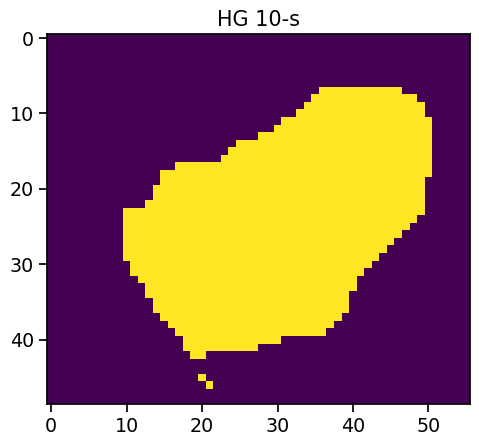

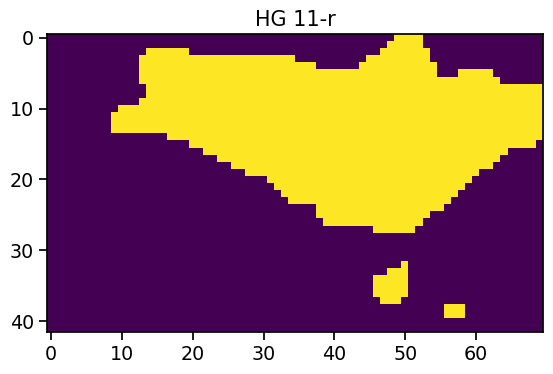

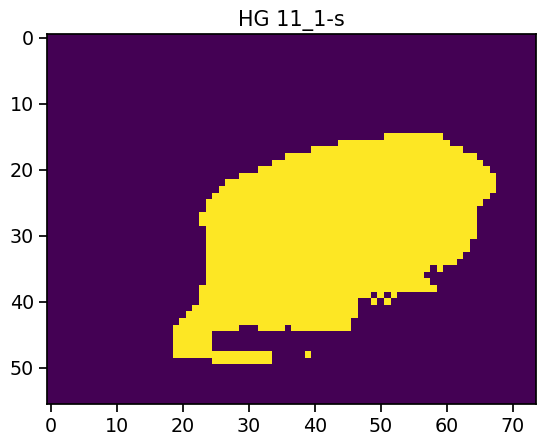

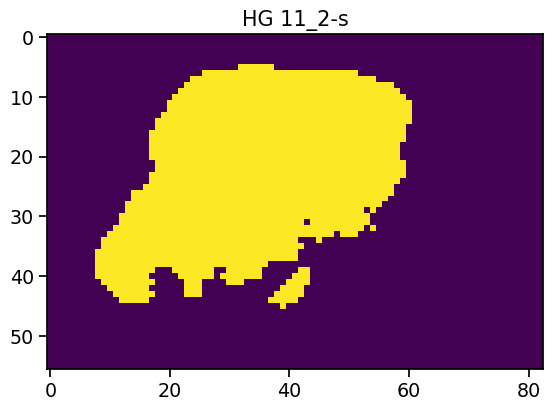

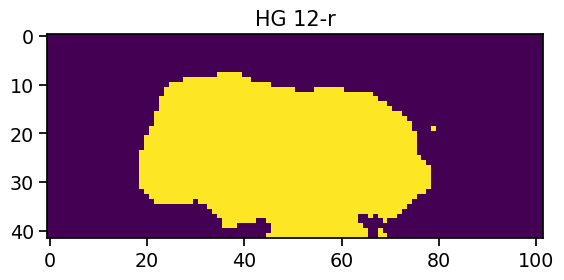

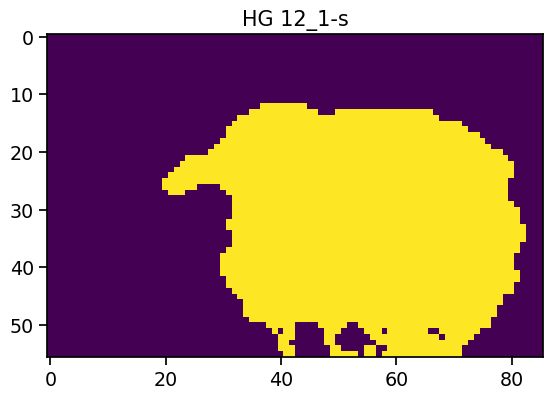

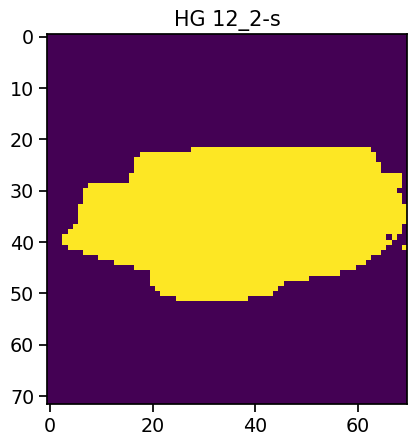

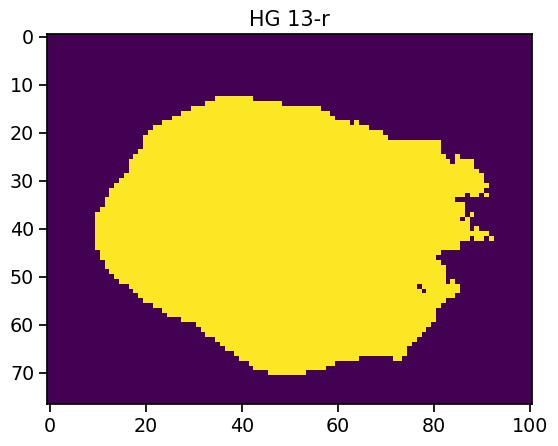

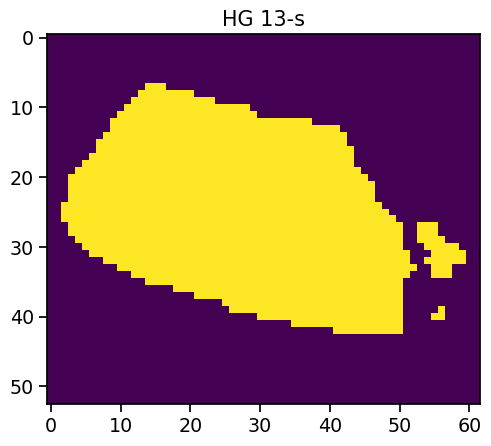

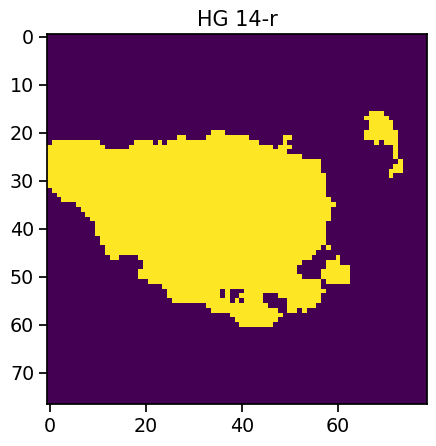

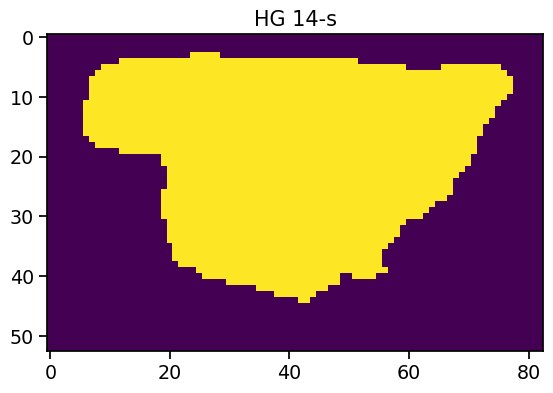

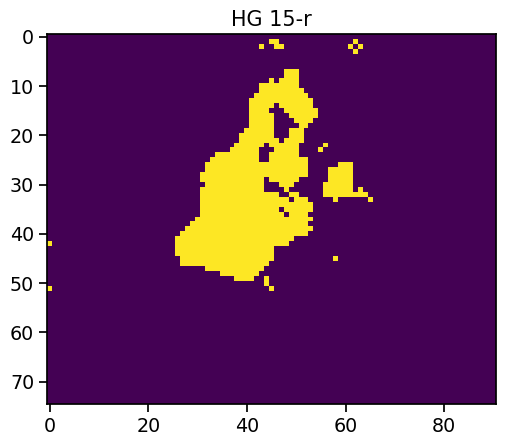

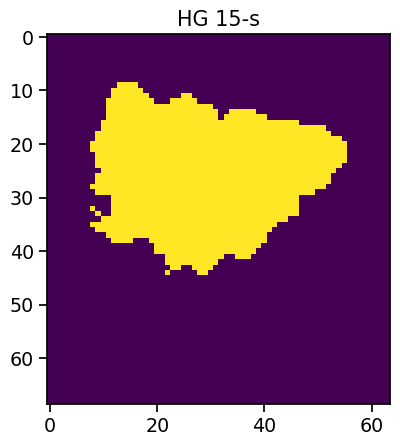

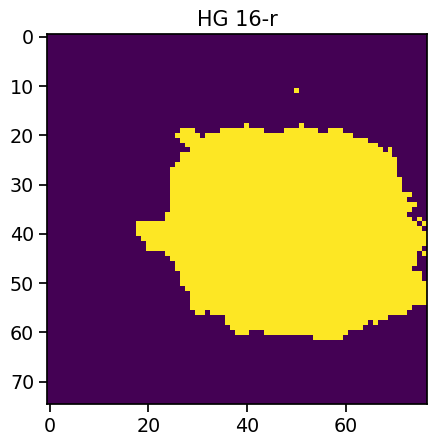

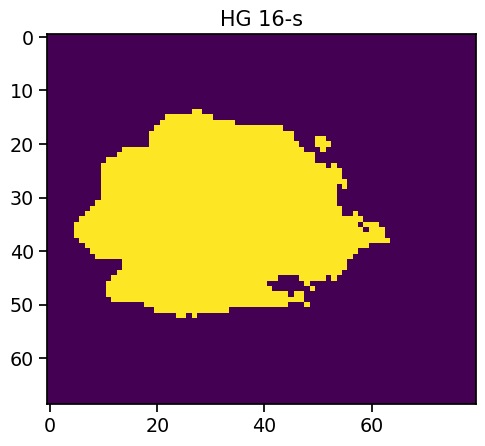

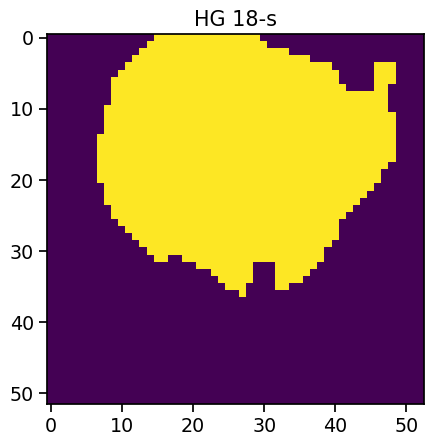

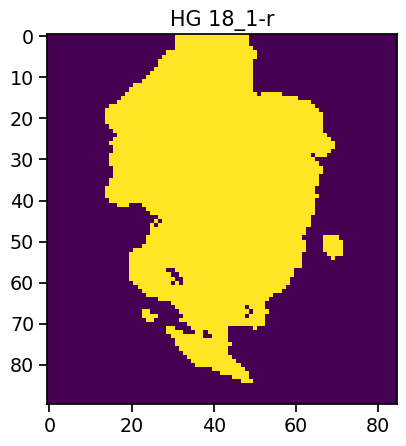

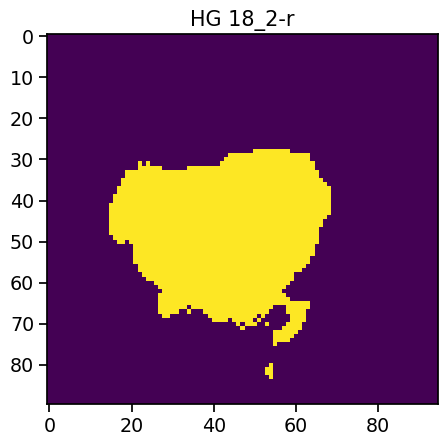

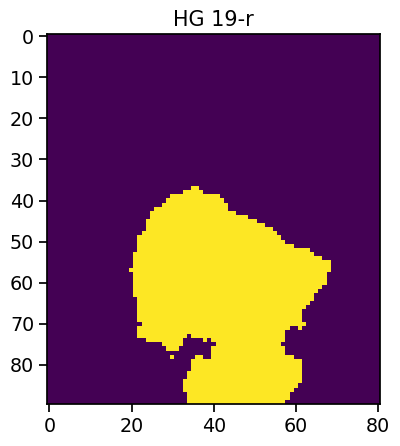

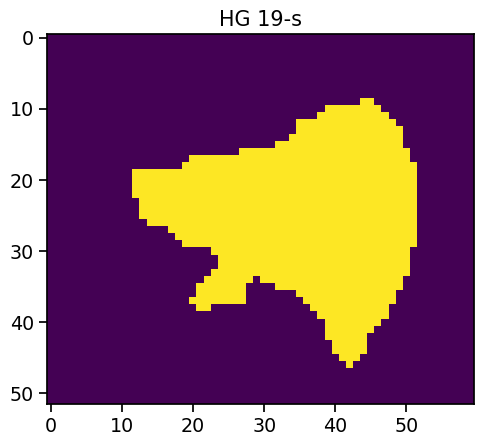

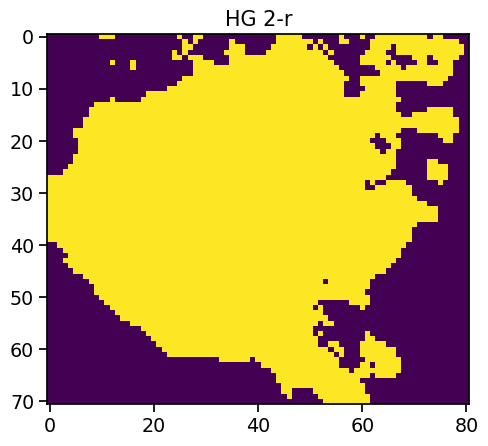

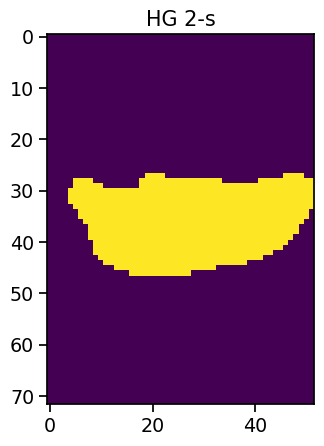

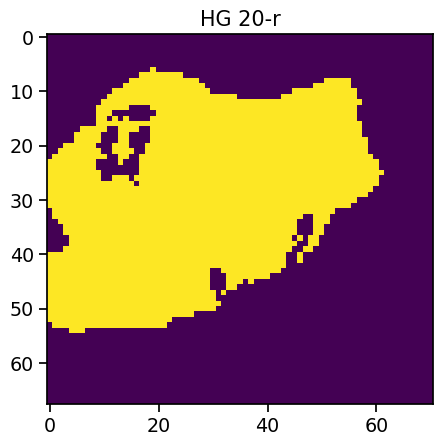

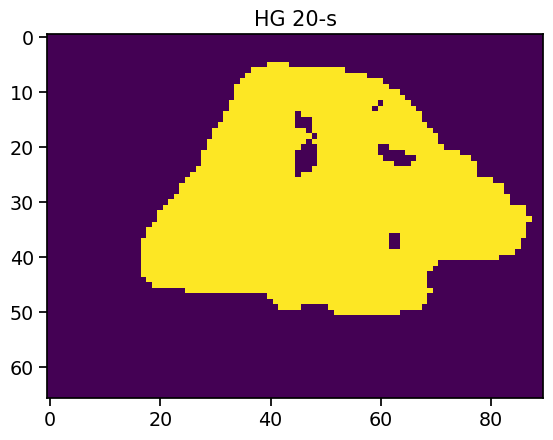

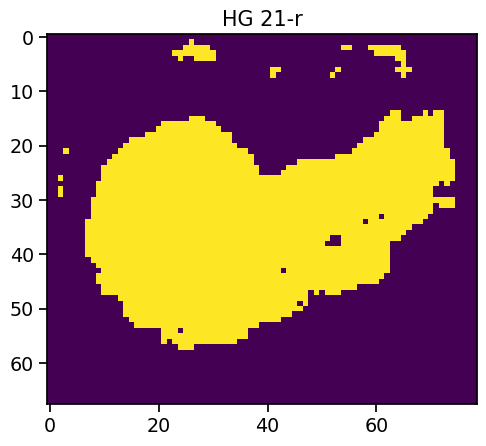

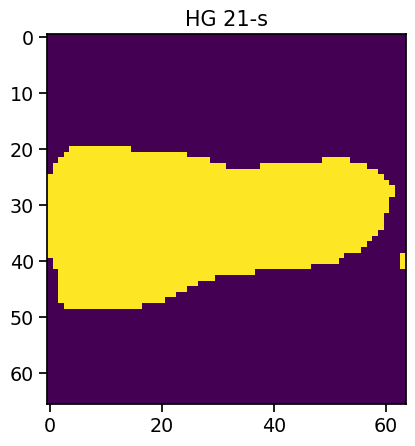

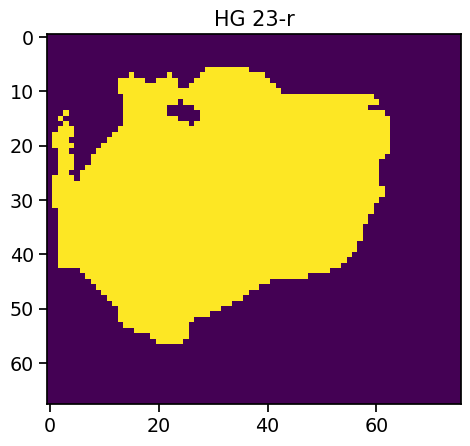

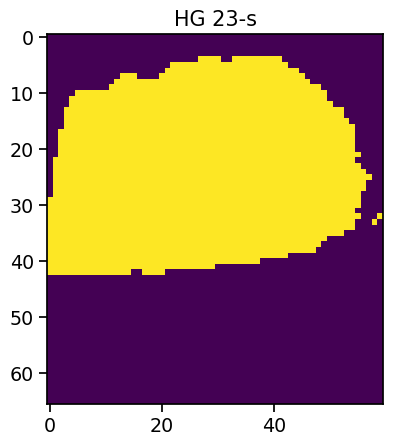

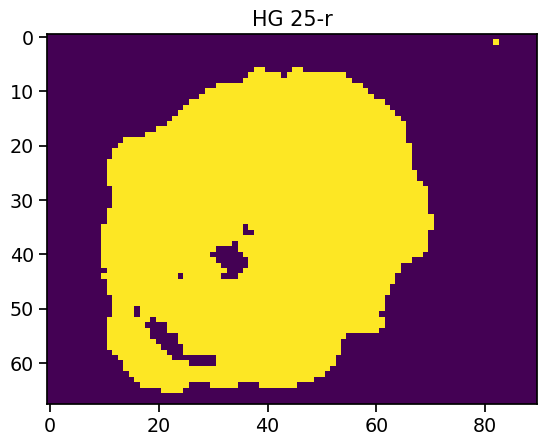

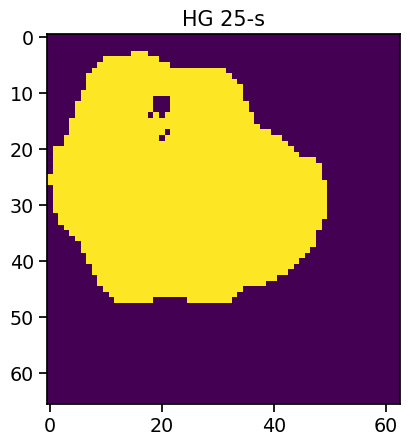

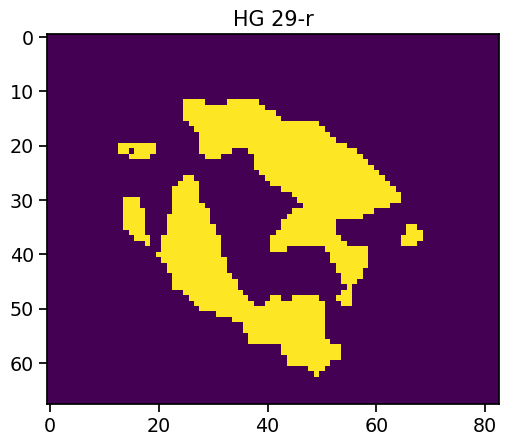

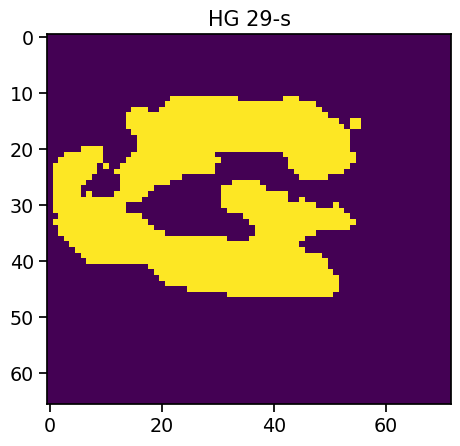

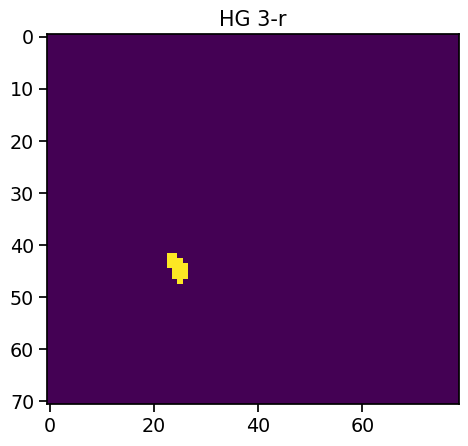

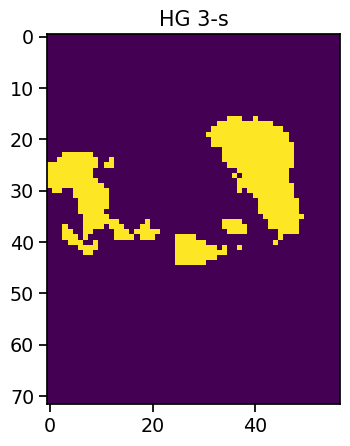

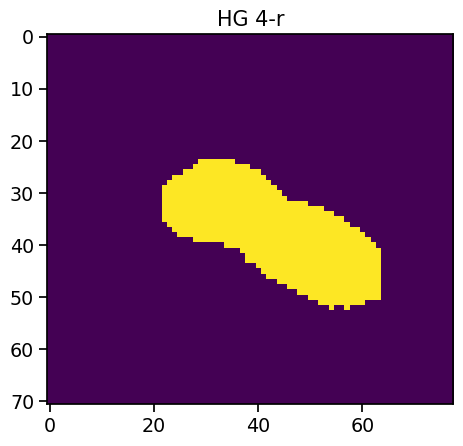

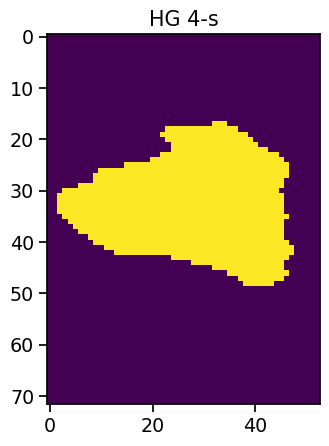

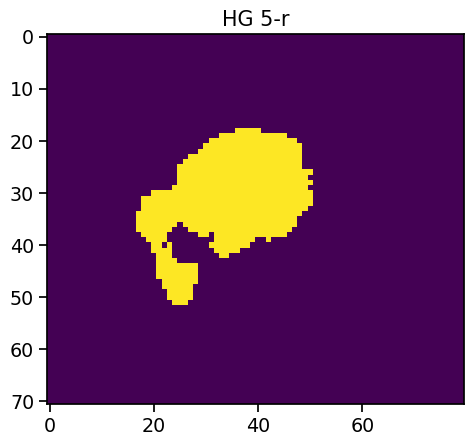

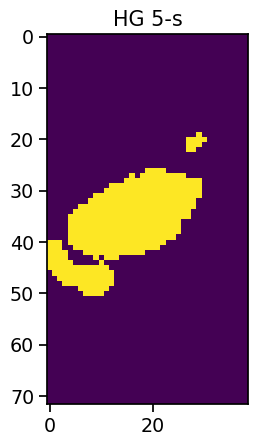

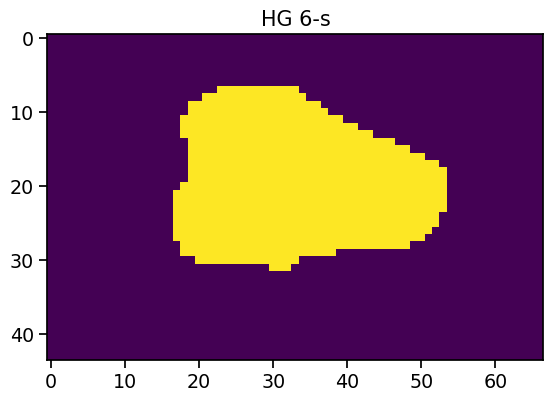

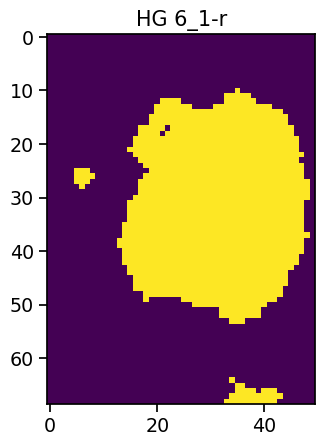

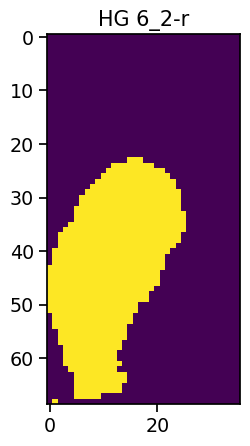

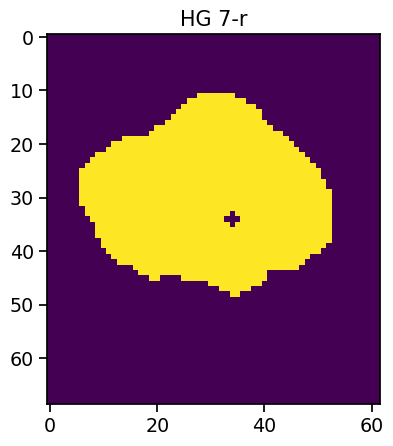

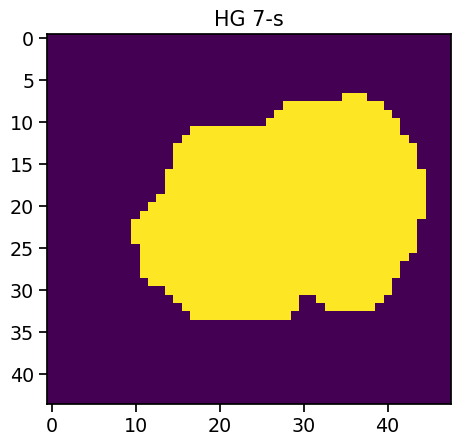

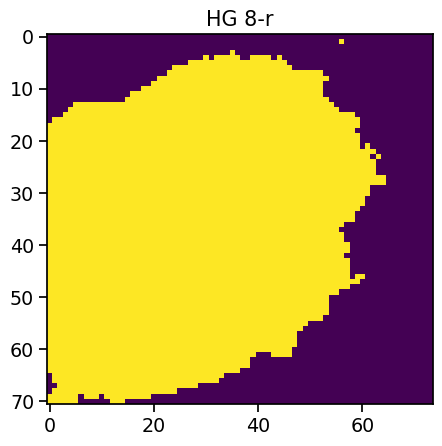

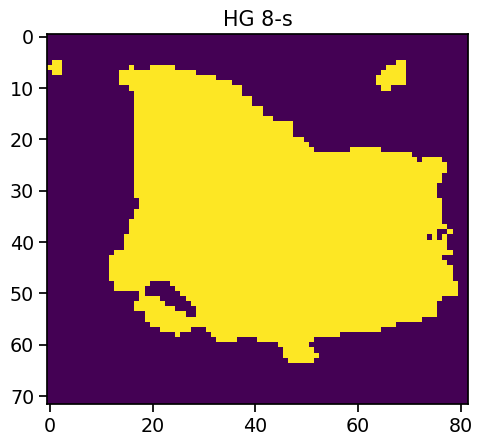

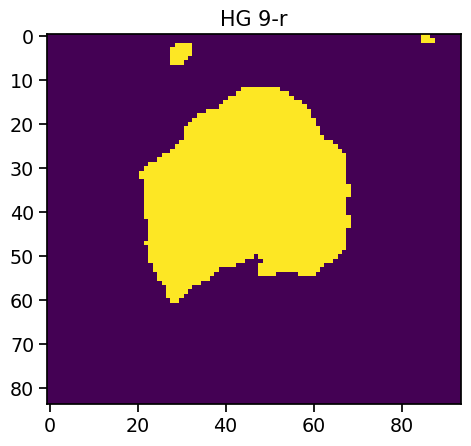

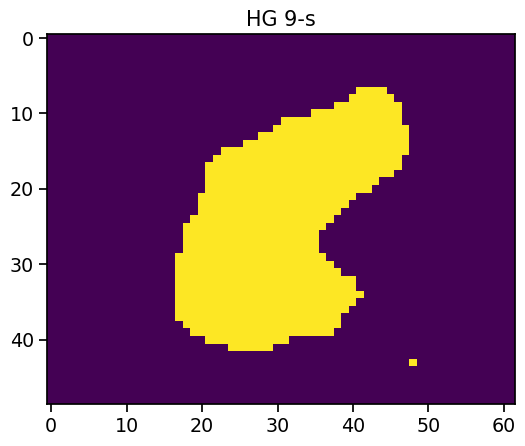

In [78]:
from matplotlib import pyplot as plt

# Loop through the files
for p in sorted(list(Path(PROCESSED_DATA).iterdir())):
  img_segmented = np.load(p / "segmentation.npy")
  plt.imshow(img_segmented)
  plt.title(p.stem)
  plt.show()

# 3 should be removed as segmentation failed
# 18, 19 should be removed as segmentation failed

In [ ]:
# Plot the number of files each mz value appears in
plt.plot(
    list(mzs_values_file_count.keys()), list(mzs_values_file_count.values()),
    'o'
)
plt.tight_layout()
plt.show()
# Plot the histogram of the number of files each mz value appears in
plt.hist(list(mzs_values_file_count.values()), bins=100)
plt.tight_layout()
plt.show()

In [46]:
import numpy as np


def align_peaks_seed_method(peak_lists, tolerance=0.02):
  # Step 1: Concatenate all peak lists into one array
  all_peaks = np.concatenate(peak_lists)

  # Step 2: Sort the peaks
  all_peaks.sort()

  # Step 3: Initialize a list to hold the aligned peaks (seeds)
  aligned_peaks = []
  current_seed = all_peaks[0]  # Start with the first peak as the seed

  # Step 4: Traverse through the sorted peaks and use them as seeds
  for peak in all_peaks:
    if not aligned_peaks or peak - aligned_peaks[-1] >= tolerance:
      aligned_peaks.append(peak)

  # Step 5: For each list, find the closest candidate for each seed
  adjusted_peak_lists = []
  for peaks in peak_lists:
    adjusted_peaks = []
    for seed in aligned_peaks:
      # Find all peaks within tolerance of the seed
      candidates = [p for p in peaks if abs(p - seed) < tolerance]
      if candidates:
        # Choose the candidate closest to the seed
        closest_peak = min(candidates, key=lambda p: abs(p - seed))
        adjusted_peaks.append(closest_peak)
      else:
        # If no candidate found, append None (or handle it as needed)
        adjusted_peaks.append(None)
    adjusted_peak_lists.append(adjusted_peaks)

  return adjusted_peak_lists


# Example usage:
peak_lists = [
    [100.01, 100.03, 100.05], [100.02, 100.04, 100.06], [99.98, 100.00, 100.08]
]

aligned_peaks = align_peaks_seed_method(peak_lists, tolerance=0.02)
for i, peaks in enumerate(aligned_peaks):
  print(f"List {i+1} aligned peaks: {peaks}")

List 1 aligned peaks: [None, 100.01, 100.05, None]
List 2 aligned peaks: [None, 100.02, 100.04, 100.06]
List 3 aligned peaks: [99.98, 100.0, None, 100.08]
